# Text mining on reviews (document-term matrix)

## 0. Libraries and data

In [1]:
# base packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Text handling packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LsiModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modelling packages
from lightgbm import LGBMClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import hamming_loss
from sklearn.multioutput import ClassifierChain
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.manifold import TSNE
import warnings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [35]:
df = pd.read_csv('APF_NF_N.csv', sep=";")
df.head()

,APF,hotel_ID,review_country,rating,title_review,characters_title_review,text_review,characters_text_review,characters_TOTAL,categories,...,Express_hope,Invite_for_future_contact,Pos_mov_TOTAL,Intensify_pos_move_Adj_Adv_standard,Intensify_pos_move_Adj_Adv_original,Intensify_pos_move_excl,Intensify_pos_move_emoticon,Intensify_pos_move_interjection,Intensify_pos_move_caps,Intensify_pos_move_TOTAL
0,48065319,528801,NL,83,Een nacht met goede nachtrust.,30,"(+) Goede kamer, goed bed, inloopdouche fijn v...",78,108,"room comfort+,bed comfort+,room other+,separat...",...,NaN,NaN,4,2.0,2.0,1.0,NaN,NaN,NaN,5.0
1,48146479,279241,BE,83,Zalig,5,(+) Zeer uitgebreid ontbijt en lekker!,38,43,"overall location+,clean room+,breakfast qualit...",...,NaN,NaN,3,2.0,1.0,NaN,NaN,NaN,NaN,3.0
2,48181343,279073,NL,100,"Top! Goede locatie, binnen 5 minuten met de me...",65,"""(+) De hygiëne en de inrichting van de kamers...",58,123,"overall location+,public transport distance+,c...",...,NaN,NaN,3,1.0,1.0,1.0,NaN,NaN,NaN,3.0
3,48671303,528801,NL,92,NaN,0,"(+) Goede bedden, makkelijk bereikbaar vanaf s...",113,113,"overall location+,major road distance+,room co...",...,NaN,NaN,4,1.0,1.0,1.0,NaN,NaN,NaN,3.0
4,48680631,279625,Afghanistan,83,Rustig and comfortabel appartement in hartje v...,63,"(+) Heerlijk bed. Veel TV kanalen, Goede voorz...",143,206,"quiet area+,apartment comfort+,bed comfort+,ap...",...,NaN,NaN,4,2.0,1.0,1.0,NaN,NaN,NaN,4.0


In [36]:
# delete rows with empty reviews
index_NA = df[df.text_review.isnull().values].index
df = df.drop(index=index_NA)

In [37]:
# select text columns from dataset 
body = pd.DataFrame(df.loc[:,'text_review'])
body.isna().sum()

text_review    0
dtype: int64

In [38]:
body

,text_review
0,"(+) Goede kamer, goed bed, inloopdouche fijn v..."
1,(+) Zeer uitgebreid ontbijt en lekker!
2,"""(+) De hygiëne en de inrichting van de kamers..."
3,"(+) Goede bedden, makkelijk bereikbaar vanaf s..."
4,"(+) Heerlijk bed. Veel TV kanalen, Goede voorz..."
...,...
1474,"""(+) Ontbijt was heerlijk, alles was aanwezig ..."
1475,"""(+) Bedden waren schoon\n\n(-) Oud! Garage ou..."
1476,"(-) enorme renovatie in het pand, dus naast he..."
1477,"""(+) Het ontbijt De service\n\n(-) De kamer wa..."


In [39]:
# create response dataset
# make data 
Y = df.iloc[:,18:26]
Y[Y > 1] = 1
Y = Y.fillna(0).astype(int)
Y

,Thank_Appreciation,Sollicit_future_visit,Positive_closing_wish,Express_positive_feeling,Compliment_as_motivator,Refer_compliment,Promote_facility_service_values,Express_hope
0,1,1,0,1,0,0,0,0
1,1,1,0,1,0,0,0,0
2,1,1,0,1,0,0,0,0
3,1,1,0,1,0,0,0,0
4,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1474,0,0,0,0,0,0,0,0
1475,0,0,0,0,0,0,0,0
1476,0,0,0,0,0,0,0,0
1477,0,0,0,0,0,0,0,0


## 1. Clean data 

Classic steps in cleaning text data
1. Put everything to lowercase
2. get rid of punctuation
3. get rid of numbers
4. get rid of stopwords
5. standardize words using lemmatiziation

### 1.1 Remove punctuation, numbers and non alphabetic characters

In [40]:
# make all characters lowercase and remove punctuation and (+) & (-) & \n
def clean_text(text):
    text = text.lower()
    # remove non alphabetic characters
    text = re.sub('[(+)|(-)|\n|"|“”|‘’]', '', text)
    # remove digits
    text = re.sub('\d+', '', text)
    # remove puncutation
    text = re.sub('[%s]+' % re.escape(string.punctuation), '', text)
    # remove redundant spaces
    text = re.sub('\s+', ' ', text).strip()
    return text

In [41]:
for i in range(30):
    print(body.iloc[i,0])

(+) Goede kamer, goed bed, inloopdouche fijn voor gehandicapten. Toilet apart.
(+) Zeer uitgebreid ontbijt en lekker!
"(+) De hygiëne en de inrichting van de kamers.

(-) Niks"
(+) Goede bedden, makkelijk bereikbaar vanaf snelweg, mooie moderne inrichting. Goede prijs-/kwaliteitverhouding.
(+) Heerlijk bed. Veel TV kanalen, Goede voorzieningen, handige keuken. Rustig aan binnen plein gelegen kamer. Relatief goedkope parkeerplaats.
(+) Locatie
"(+) Goed ontbijt , extraatje: mogelijkheid om zelf een wafeltje te bakken.

(-) geen negatieve commentaar"
(+) Toen we binnen kwamen was er een lekker geurtje.  Zeer vriendelijk onthaalt.  Ook de inrichting van het hotel sprak mij enorm aan.  En heel lekker ontbijt. Top !!
(+) Het geheel
"(+) Fijne inrichting & decoratie vd kamers & restaurant !

(-) Kamer met zicht op het plein aangenaam maar wel last van straatlawaai ."
(+) De vriendelijke service en hulp van het personeel.  De uitstekende ligging hartje Kortrijk.  Het uitgebreide ontbijt met v

In [42]:
body['clean_text'] = body['text_review'].apply(lambda x: clean_text(x))

In [43]:
for i in range(30):
    print(body.iloc[i,1])

goede kamer goed bed inloopdouche fijn voor gehandicapten toilet apart
zeer uitgebreid ontbijt en lekker
de hygiëne en de inrichting van de kamers niks
goede bedden makkelijk bereikbaar vanaf snelweg mooie moderne inrichting goede prijskwaliteitverhouding
heerlijk bed veel tv kanalen goede voorzieningen handige keuken rustig aan binnen plein gelegen kamer relatief goedkope parkeerplaats
locatie
goed ontbijt extraatje mogelijkheid om zelf een wafeltje te bakken geen negatieve commentaar
toen we binnen kwamen was er een lekker geurtje zeer vriendelijk onthaalt ook de inrichting van het hotel sprak mij enorm aan en heel lekker ontbijt top
het geheel
fijne inrichting decoratie vd kamers restaurant kamer met zicht op het plein aangenaam maar wel last van straatlawaai
de vriendelijke service en hulp van het personeel de uitstekende ligging hartje kortrijk het uitgebreide ontbijt met vooral het versgeperste fruitsap en de heerlijke koffie
prima plek om te slapen rustig en proper hotel voor de

### 1.2 Remove stopwords

In [44]:
def remove_stopwords(text, stop_words):
    text = [word for word in text.split(' ') if word not in stop_words]
    return ' '.join(text)

In [45]:
stop_words = stopwords.words('dutch')
body['clean_text'] = body['clean_text'].apply(lambda x: remove_stopwords(x, stop_words))

In [46]:
body.head()

,text_review,clean_text
0,"(+) Goede kamer, goed bed, inloopdouche fijn v...",goede kamer goed bed inloopdouche fijn gehandi...
1,(+) Zeer uitgebreid ontbijt en lekker!,zeer uitgebreid ontbijt lekker
2,"""(+) De hygiëne en de inrichting van de kamers...",hygiëne inrichting kamers niks
3,"(+) Goede bedden, makkelijk bereikbaar vanaf s...",goede bedden makkelijk bereikbaar vanaf snelwe...
4,"(+) Heerlijk bed. Veel TV kanalen, Goede voorz...",heerlijk bed tv kanalen goede voorzieningen ha...


### 1.3 Lemmatizing 

In [47]:
# import dutch library
def perform_lemmatizing(text, core):
    sentence = core(text)
    transformed = [word.lemma_ for word in sentence]
    return ' '.join(transformed)

In [48]:
nlp = spacy.load("nl_core_news_sm")

In [49]:
body['clean_text_lemma'] = body['clean_text'].apply(lambda x: perform_lemmatizing(x, nlp))

In [50]:
body.head()

,text_review,clean_text,clean_text_lemma
0,"(+) Goede kamer, goed bed, inloopdouche fijn v...",goede kamer goed bed inloopdouche fijn gehandi...,goed kamer goed bed inloopdouch fijn gehandica...
1,(+) Zeer uitgebreid ontbijt en lekker!,zeer uitgebreid ontbijt lekker,zeer uitbreiden ontbijt lekker
2,"""(+) De hygiëne en de inrichting van de kamers...",hygiëne inrichting kamers niks,hygiëne inrichting kamer niks
3,"(+) Goede bedden, makkelijk bereikbaar vanaf s...",goede bedden makkelijk bereikbaar vanaf snelwe...,goed bed makkelijk bereikbaar vanaf snelweg mo...
4,"(+) Heerlijk bed. Veel TV kanalen, Goede voorz...",heerlijk bed tv kanalen goede voorzieningen ha...,heerlijk bed tv kanaal goed voorziening handig...


### 1.4 Make document-term matrix

In [19]:
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)

In [20]:
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
dtm_CV

,aanbevel,aanbevelen,aanbeveling,aanbieden,aanbieding,aanbod,aandacht,aandoen,aandringen,aanduiden,...,zwembad,zwembadruimte,zwemmen,zweterig,zwier,zwijgen,zéér,één,éénvoudig,óók
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Visualizations

### 2.1 Most common words

In [21]:
# if some words that are mostly used are not useful add them to the stopwords to delete and 
# perfrom the count vectorizer again 
# find the most common words over all the documtents
dtm = dtm_CV.transpose()
dtm.sum(axis=1).sort_values(ascending=False).head(30)

kamer          1085
ontbijt         623
goed            476
hotel           414
we              339
bed             320
personeel       319
zeer            259
vriendelijk     254
heel            251
locatie         242
klein           202
prima           201
badkamer        199
erg             189
wel             184
ligging         154
mooi            148
wij             147
liggen          140
schoon          138
prijs           134
hebben          131
ruim            131
lekker          114
slecht          111
gaan            110
komen           110
heerlijk        109
leuk            105
dtype: int64

Some words can also be categorized as stopwords: we, wel, wij -> remove these words

In [53]:
# add new stopwords to remove
stop_words = stop_words + (['we', 'wel','wij', 'komen','gaan','vinden'])

# remove stopwords from the text
body['clean_text_lemma'] = body['clean_text_lemma'].apply(lambda x: remove_stopwords(x, stop_words))

# initialize the document term matrix again 
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# transpose data and calculate for each token the number of occurences
dtm = data_dtm.transpose()
dtm.sum(axis=1).sort_values(ascending=False).head(30)

kamer          1085
ontbijt         623
goed            476
hotel           414
bed             320
personeel       319
zeer            259
vriendelijk     254
heel            251
locatie         242
klein           202
prima           201
badkamer        199
erg             189
ligging         154
mooi            148
liggen          140
schoon          138
prijs           134
ruim            131
lekker          114
slecht          111
heerlijk        109
leuk            105
douche          103
krijgen         102
net             102
staan            95
nacht            92
centrum          91
dtype: int64

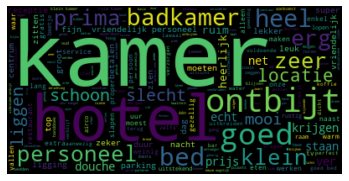

In [23]:
# make 1 string with all the text in it
text = ''.join(word for word in body.clean_text_lemma)

# make plots 
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
body.to_csv(r'C:\Users\DB Accountancy\Documents\Master statistical data analysis\MASTERPROEF\jupyter\body.csv', header=True)

In [55]:
for i in range(50):
    print(i)
    print(body.iloc[i,0])

0
(+) Goede kamer, goed bed, inloopdouche fijn voor gehandicapten. Toilet apart.
1
(+) Zeer uitgebreid ontbijt en lekker!
2
"(+) De hygiëne en de inrichting van de kamers.

(-) Niks"
3
(+) Goede bedden, makkelijk bereikbaar vanaf snelweg, mooie moderne inrichting. Goede prijs-/kwaliteitverhouding.
4
(+) Heerlijk bed. Veel TV kanalen, Goede voorzieningen, handige keuken. Rustig aan binnen plein gelegen kamer. Relatief goedkope parkeerplaats.
5
(+) Locatie
6
"(+) Goed ontbijt , extraatje: mogelijkheid om zelf een wafeltje te bakken.

(-) geen negatieve commentaar"
7
(+) Toen we binnen kwamen was er een lekker geurtje.  Zeer vriendelijk onthaalt.  Ook de inrichting van het hotel sprak mij enorm aan.  En heel lekker ontbijt. Top !!
8
(+) Het geheel
9
"(+) Fijne inrichting & decoratie vd kamers & restaurant !

(-) Kamer met zicht op het plein aangenaam maar wel last van straatlawaai ."
10
(+) De vriendelijke service en hulp van het personeel.  De uitstekende ligging hartje Kortrijk.  Het ui

In [33]:
body.iloc[59,:]

text_review         "(+) Alles\n\n(-) Niets"
clean_text                                  
clean_text_lemma                            
Name: 61, dtype: object

In [3]:
body = pd.read_csv("body.csv")

## LSA (latent semantical analysis)

### Default values

In [23]:
# make document term matrix
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

In [24]:
# perform LSA 
lsa_obj = TruncatedSVD(n_components=100, n_iter=100, random_state=0)
lsa_data = lsa_obj.fit_transform(dtm_CV)

### Evaluation

#### Explained variance

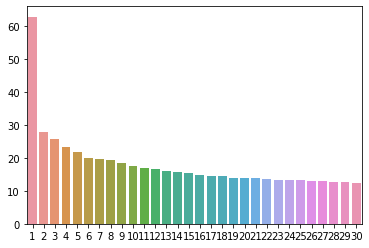

<AxesSubplot:>

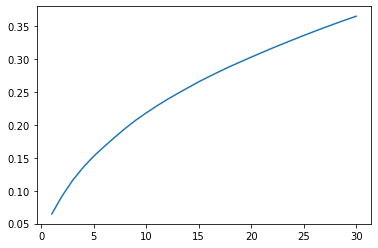

In [26]:
# plot singular values & explained variance of the first 100 components
sigma = lsa_obj.singular_values_ # how important is this topic in explaining the data 
var_exp = lsa_obj.explained_variance_ratio_
V_T = lsa_obj.components_.T
sns.barplot(x=list(range(1,31)), y=sigma[:30])
plt.show()
sns.lineplot(x = list(range(1,31)), y=np.cumsum(var_exp[:30]))

### Documents topics

In [27]:
# show documents assigned to topics
doc_top_df = pd.DataFrame(lsa_data, 
                          columns = [f'topic_{r}' for r in range(0,V_T.shape[1])],
                         index = body['clean_text_lemma'])
doc_top_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
clean_text_lemma,,,,,,,,,,,,,,,,,,,,,
goed kamer goed bed inloopdouch fijn gehandicapt toilet apart,1.432245,0.328941,-0.475363,1.690818,0.462805,0.066240,-0.112800,-0.359022,-0.062100,-0.202226,...,0.015304,0.016632,0.019453,0.027288,0.052630,0.009904,-0.054879,-0.055583,-0.091623,0.028179
zeer uitbreiden ontbijt lekker,0.500599,0.459843,-0.709263,-0.856078,0.337832,0.419653,0.139296,-0.091084,0.282033,-0.159319,...,-0.000063,0.031972,-0.073639,-0.022091,0.096151,-0.000123,0.049345,0.051483,0.045529,0.126202
hygiëne inrichting kamer niks,0.699366,-0.650788,0.021776,0.058695,0.057742,-0.016784,-0.115863,-0.129799,-0.035150,-0.025972,...,0.043883,-0.020166,0.003086,0.033291,-0.107085,0.002466,-0.165328,-0.075038,-0.172755,0.066714
goed bed makkelijk bereikbaar vanaf snelweg mooi modern inrichting goed prijskwaliteitverhouding,0.810171,1.070633,-0.479080,1.591964,0.317769,0.109895,-0.100074,-0.361905,-0.097140,-0.175309,...,-0.165714,0.086126,0.016128,0.052036,0.083918,-0.031079,-0.201648,-0.099362,-0.048232,-0.017511
heerlijk bed tv kanaal goed voorziening handig keuken rustig binnen plein liggen kamer relatief goedkoop parkeerplaats,1.312947,0.075879,-0.275796,1.141890,0.110313,0.075759,0.367362,-0.501072,0.200743,0.161491,...,0.212436,-0.411359,-0.083641,0.018841,0.074694,-0.018745,-0.160143,-0.227609,0.204464,0.171495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ontbijt heerlijk aanwezig verwachten bedanken winter hotel boeken denken verwarming badkamer bedenking,0.776834,0.697683,0.194465,-0.779867,0.382270,-0.317656,0.505468,-0.194850,0.201431,0.142640,...,-0.053781,-0.068257,0.011440,0.100225,-0.080875,-0.194739,-0.113788,0.167561,-0.007083,0.144831
bed schoon oud garage oud kamer geupdat water afsluiten douche gordijn douche bidden slecht ventalatie ver centrum raam openen euro parking nooit naartoe booking maken mooi foto overeen duur zeker ster waardig heel jammer,1.738934,-0.019241,0.208209,0.408429,-0.687979,0.099758,0.816526,0.028549,-0.308448,-0.234717,...,-0.239978,-0.471056,-0.330506,-0.454203,-0.812587,0.319804,0.378723,-0.016180,0.156692,0.609276
enorm renovatie pand naast bed liggen letterlijk oordop excuus daarnaast hotel nogal massaal kamer relatief klein,1.338550,-0.117421,0.635938,0.281414,-0.180341,0.135027,0.813274,-0.380995,0.638371,0.059886,...,-0.085160,-0.156106,-0.366531,-0.040371,0.079457,0.225984,-0.300190,0.167318,-0.087044,0.150975


### Important words per topic

In [28]:
# show term-topic matrix (what words load high on topics)
term_topic_matrix = pd.DataFrame(lsa_obj.components_, 
                               index = [f'topic_{r}' for r in range(0,V_T.shape[1])], 
                               columns = cv.get_feature_names()).T
term_topic_matrix

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_90,topic_91,topic_92,topic_93,topic_94,topic_95,topic_96,topic_97,topic_98,topic_99
aanbevel,0.000170,0.000998,-0.001087,0.000177,0.001079,-0.000477,0.000238,0.001112,-0.000474,-0.000046,...,-0.000134,-0.002470,-0.002274,0.000054,0.001811,-0.000333,0.000890,0.001782,-0.001678,0.002243
aanbevelen,0.000749,-0.001784,0.001766,-0.000553,0.000923,0.003064,-0.000827,0.000280,0.000129,0.001595,...,-0.007100,-0.002548,0.000428,-0.014016,0.000784,-0.001709,-0.005131,0.000413,-0.013092,0.002452
aanbeveling,0.000533,0.000859,-0.001414,0.000617,-0.001377,-0.000801,-0.001588,-0.000750,0.000536,0.002363,...,-0.003106,-0.002487,0.001515,0.001084,-0.001970,0.000703,-0.001136,-0.003742,0.007418,-0.000609
aanbieden,0.009618,0.000375,0.002714,-0.010893,-0.011676,0.018572,-0.010825,0.014739,-0.007332,0.002785,...,0.036570,-0.009761,-0.017177,-0.017888,0.003270,-0.007621,-0.027785,0.011668,0.079157,0.036935
aanbieding,0.003084,0.002107,-0.002262,-0.004711,-0.007947,0.000705,0.008054,0.008984,0.004302,0.005763,...,0.023931,-0.040571,-0.030269,-0.037499,0.010486,0.008880,-0.022068,0.006189,-0.009814,-0.015572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwijgen,0.000300,0.001528,0.001198,0.000625,0.000091,0.001337,-0.000550,0.001405,-0.002322,0.002126,...,-0.003999,-0.007491,0.005404,-0.011786,0.004249,0.000756,-0.004544,-0.011260,-0.008818,-0.008849
zéér,0.001570,-0.001330,-0.001303,-0.001928,-0.000698,0.000835,-0.001602,-0.002037,-0.000877,-0.003377,...,0.001335,-0.006022,0.016599,0.000699,-0.012205,-0.001734,-0.017445,0.008518,-0.014238,-0.013594
één,0.036883,-0.012391,0.043987,0.018830,0.015885,0.067687,0.003199,0.054233,-0.053978,0.072817,...,0.137611,-0.040906,-0.032090,-0.049822,-0.025678,0.009097,0.028163,-0.018912,0.008353,0.003124
éénvoudig,0.000384,-0.000228,0.001142,-0.000514,-0.000179,-0.001284,0.000661,-0.001765,0.001387,0.001087,...,0.000627,-0.001944,0.007565,0.005236,-0.005428,-0.005069,0.003339,0.000842,-0.004707,0.004318


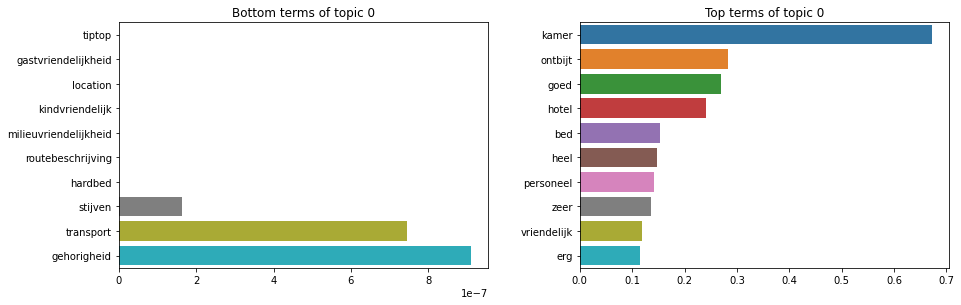

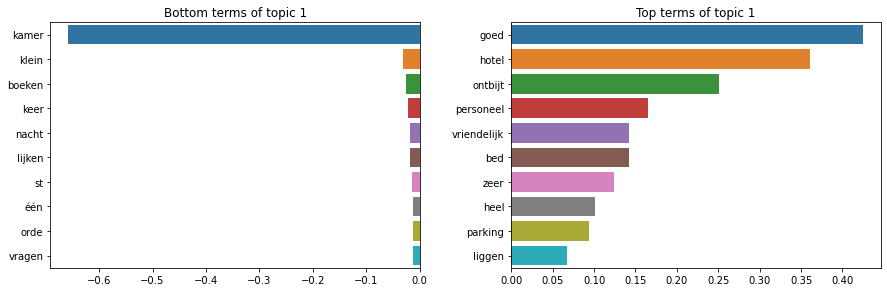

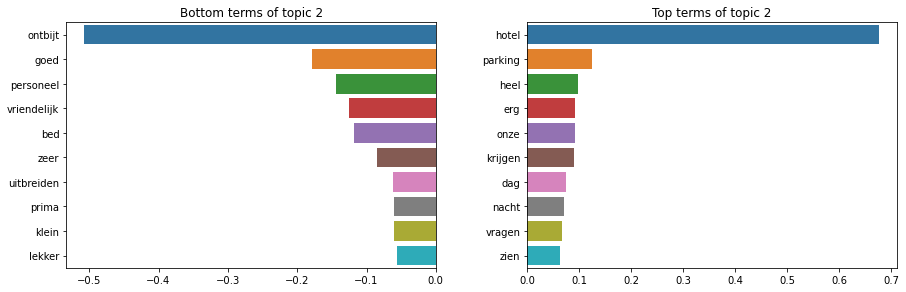

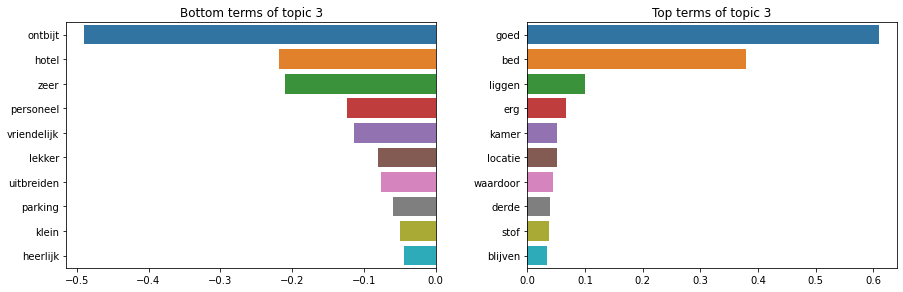

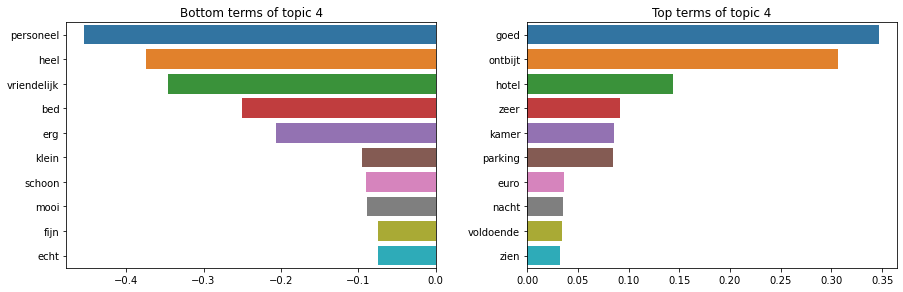

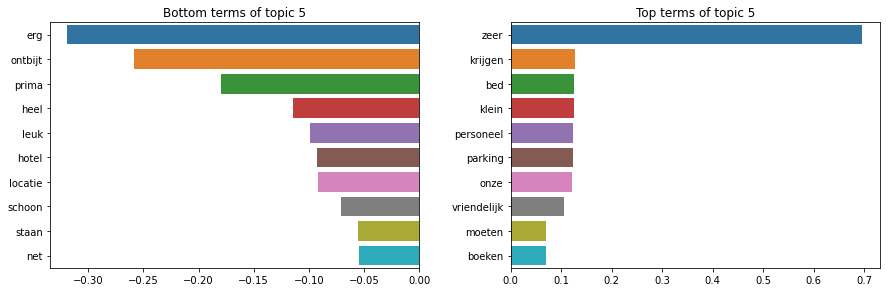

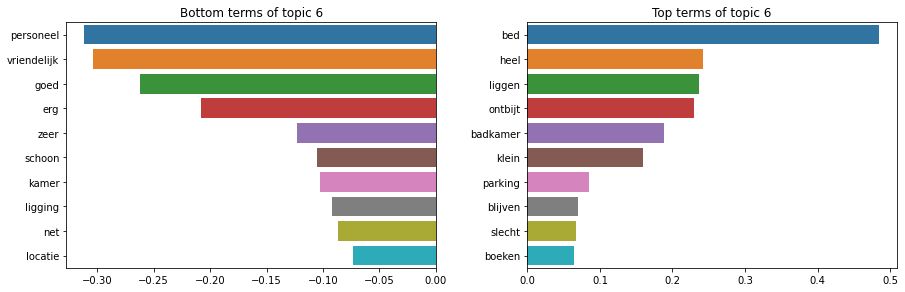

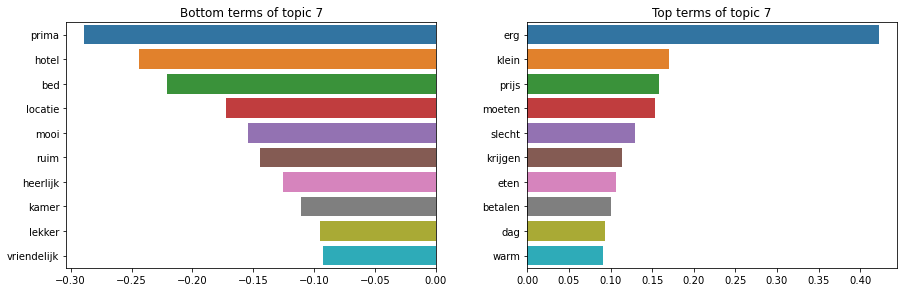

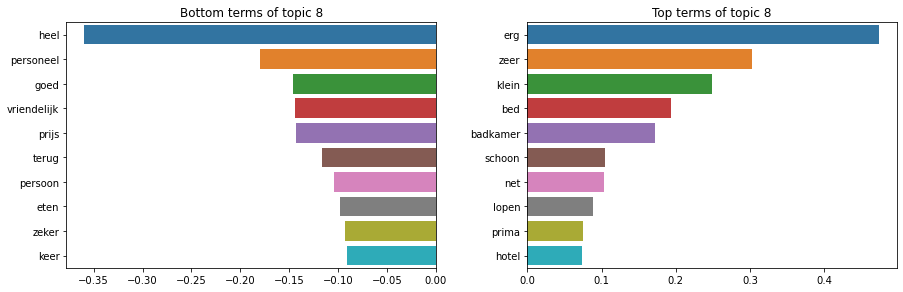

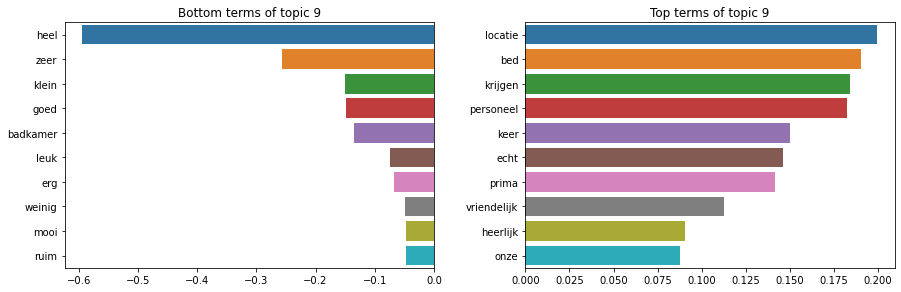

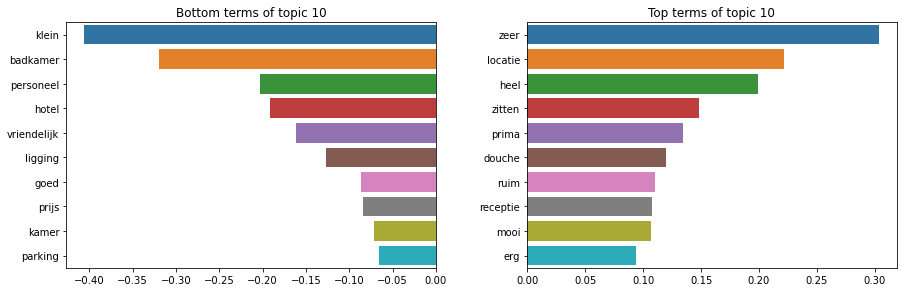

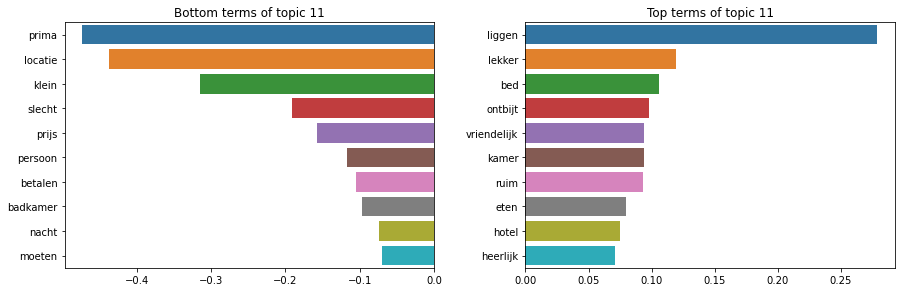

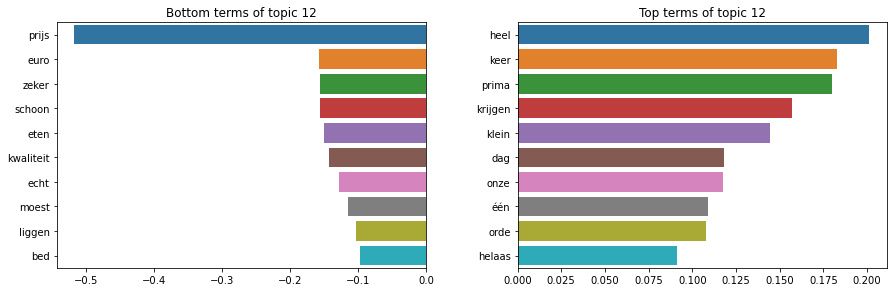

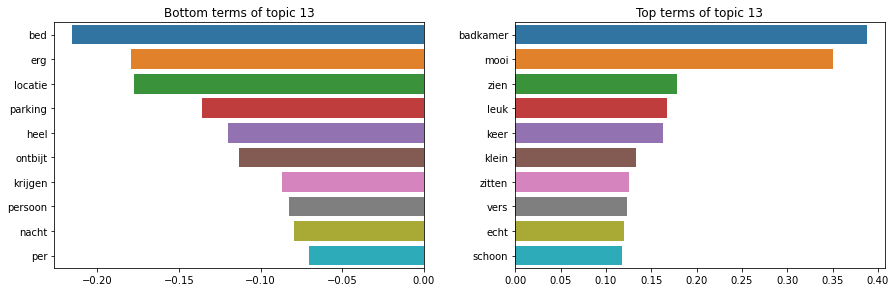

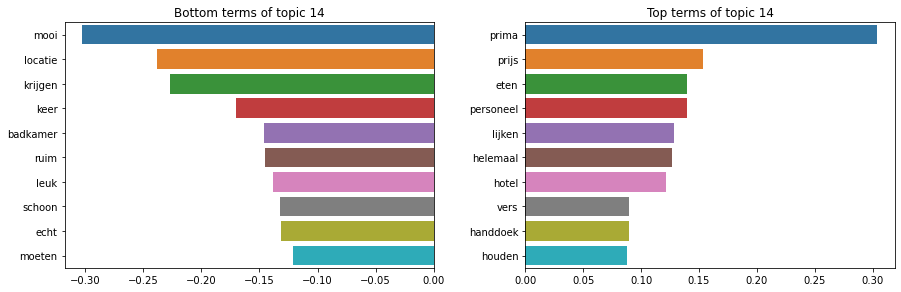

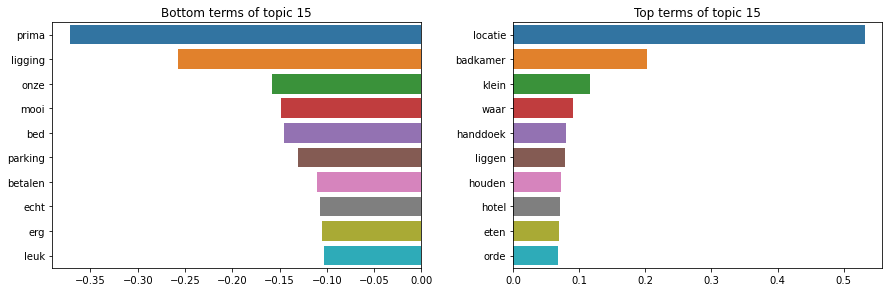

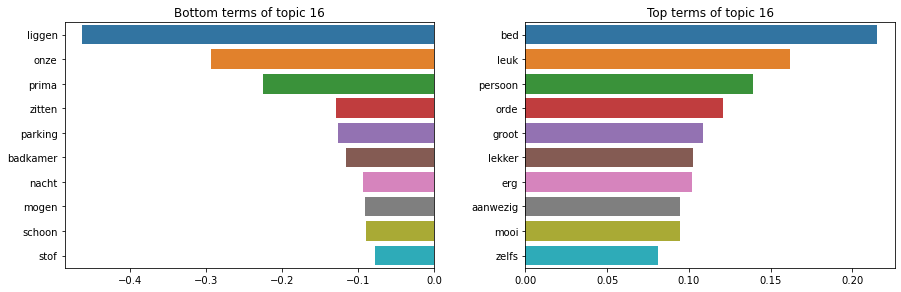

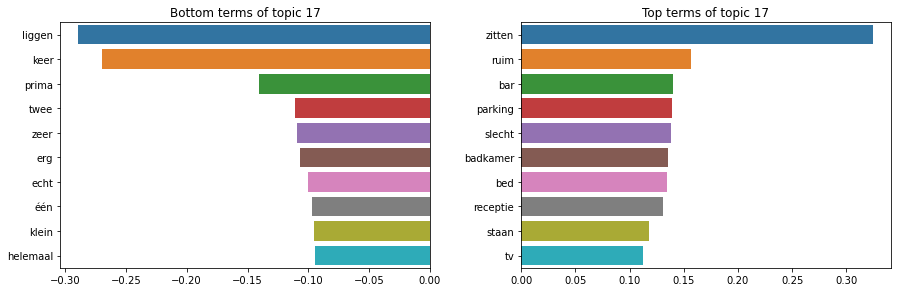

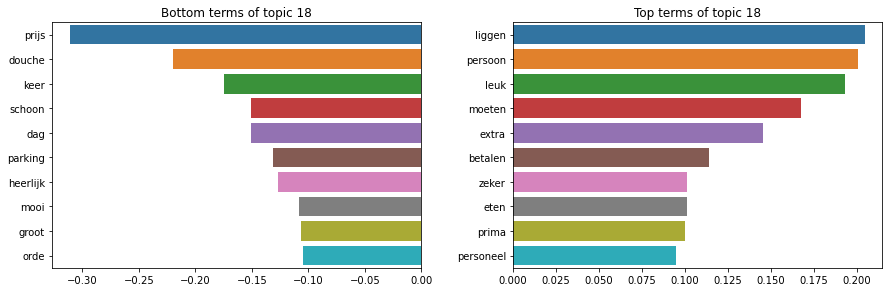

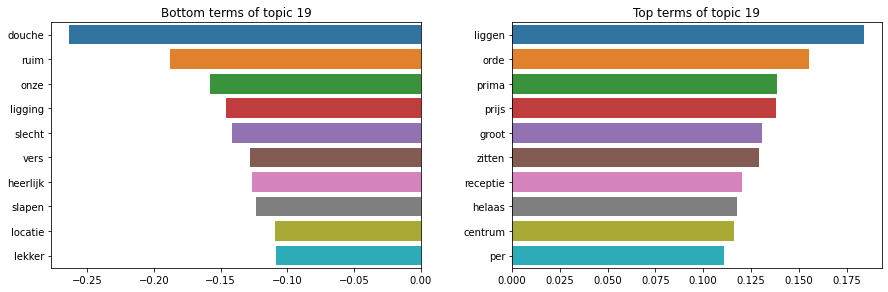

In [29]:
# plot most important words per topic
for i in range(20):
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    plt.subplots_adjust(right=2)
    data = term_topic_matrix[f'topic_{i}']
    data_pos = data.sort_values(ascending=False)
    data_neg = data.sort_values(ascending=True)
    top_10_pos = data_pos[:10]
    top_10_neg = data_neg[:10]
    plt.title(f'Important terms of topic {i}')
    ax[0].set_title(f'Bottom terms of topic {i}')
    ax[1].set_title(f'Top terms of topic {i}')
    sns.barplot(x= top_10_neg.values, y=top_10_neg.index, ax=ax[0])
    sns.barplot(x= top_10_pos.values, y=top_10_pos.index, ax=ax[1])
    #ax[0].set_xlim([min(top_10_neg.values), max(top_10_neg.values)])

### Find the best number of topics using coherence score

In [27]:
# make data in required format for gensim
data = []
for text in body['clean_text_lemma']:
    data.append(simple_preprocess(text))
    print(text)

goed kamer goed bed inloopdouch fijn gehandicapt toilet apart
zeer uitbreiden ontbijt lekker
hygiëne inrichting kamer niks
goed bed makkelijk bereikbaar vanaf snelweg mooi modern inrichting goed prijskwaliteitverhouding
heerlijk bed tv kanaal goed voorziening handig keuken rustig binnen plein liggen kamer relatief goedkoop parkeerplaats
locatie
goed ontbijt extra mogelijkheid wafel bakken negatief commentaar
binnen lekker geur zeer vriendelijk onthalen inrichting hotel spreken enorm heel lekker ontbijt top
geheel
fijn inrichting decoratie vd kamer restaurant kamer zichten plein aangenaam last straatlawaai
vriendelijk service hulp personeel uitstekend ligging hart kortrijk uitbreiden ontbijt vooral versgeperst fruitsap heerlijk koffie
prima plek slapen rustig proper hotel prijs prima plek ontbijt compleet kiezen kamer eenvoudig wensen kort verblijf
hotel echt aanrader super vriendelijk onthaal gratis parking koffie water kamer mooi verzorgen kamer goed ligging zeker terug
heel fijn sfee

In [31]:
# Compute Coherence Score
id2word = corpora.Dictionary(data)
doc_term_matrix = [id2word.doc2bow(doc) for doc in data]
lsa = LsiModel(doc_term_matrix, num_topics=500, id2word = id2word)

In [32]:
coherence_model_lda = CoherenceModel(model=lsa, 
                                     texts=data, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5251013612295719


In [32]:
# find number of topics with best coherence score 
id2word = corpora.Dictionary(data)
doc_term_matrix = [id2word.doc2bow(doc) for doc in data]
values = {}
for n in range(20,200,5):
    lsa = LsiModel(doc_term_matrix, num_topics=n, id2word = id2word)
    coherence_model_lsa = CoherenceModel(model=lsa, 
                                     texts=data, 
                                     dictionary=id2word, coherence='c_v')
    values[n] = coherence_model_lsa.get_coherence()
    print(n,coherence_model_lsa.get_coherence())


20 0.48911584802230906
25 0.4861990798241294
30 0.47688102960281736
35 0.44751485533410007
40 0.43791026399873195
45 0.43277649600525464
50 0.4311848842567464
55 0.40315981291341807
60 0.4037257133522715
65 0.3947070702161052
70 0.3783190819004636
75 0.37863919170014537
80 0.3722935081752018
85 0.3735304387669265
90 0.3712196687923657
95 0.35633146860472786
100 0.35490602260964477
105 0.34751752262647934
110 0.34439566361579294
115 0.339285969895627
120 0.34189722286902063
125 0.3425731611560494
130 0.33719053496681345
135 0.34278708354174314
140 0.339222320493365
145 0.346033891698867
150 0.3387105615690934
155 0.34241233202875443
160 0.3456886013475479
165 0.3424459368007964
170 0.3497151915045526
175 0.3463534633408014
180 0.3589560003591066
185 0.3577933992673159
190 0.3579208831953553
195 0.3617244764454833


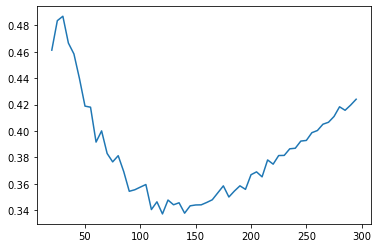

In [175]:
plt.plot(values.keys(), values.values())

In [26]:
body['clean_text_lemma']

0       goed kamer goed bed inloopdouch fijn gehandica...
1                          zeer uitbreiden ontbijt lekker
2                           hygiëne inrichting kamer niks
3       goed bed makkelijk bereikbaar vanaf snelweg mo...
4       heerlijk bed tv kanaal goed voorziening handig...
                              ...                        
1474    ontbijt heerlijk aanwezig verwachten bedanken ...
1475    bed schoon oud garage oud kamer geupdat water ...
1476    enorm renovatie pand naast bed liggen letterli...
1477    ontbijt service kamer volgens verwachting buur...
1478    vriendelijk personeel goed ontbijt bewust drie...
Name: clean_text_lemma, Length: 1440, dtype: object

30 seems to have the best coherence score so use that to predict

In [34]:
lsa_obj = TruncatedSVD(n_components=30, n_iter=100, random_state=0)
lsa_data = lsa_obj.fit_transform(dtm_CV)

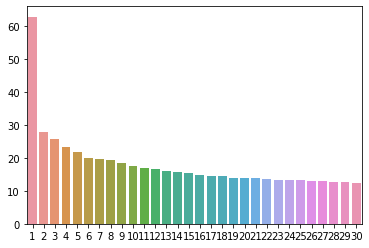

<AxesSubplot:>

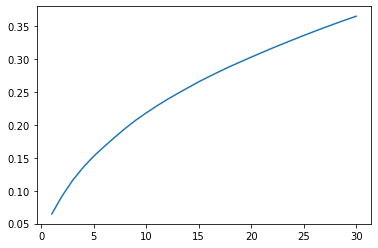

In [35]:
sigma = lsa_obj.singular_values_ # how important is this topic in explaining the data 
var_exp = lsa_obj.explained_variance_ratio_
V_T = lsa_obj.components_.T
sns.barplot(x=list(range(1,31)), y=sigma[:30])
plt.show()
sns.lineplot(x = list(range(1,31)), y=np.cumsum(var_exp))

In [36]:
# show documents assigned to topics
doc_top_df = pd.DataFrame(lsa_data, 
                          columns = [f'topic_{r}' for r in range(0,V_T.shape[1])])
doc_top_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,1.432245,0.328941,-0.475363,1.690818,0.462805,0.066240,-0.112800,-0.359022,-0.062100,-0.202226,...,0.124004,0.086520,-0.039982,-0.085127,-0.172351,-0.114831,0.169408,0.002759,-0.111393,-0.070897
1,0.500599,0.459843,-0.709263,-0.856078,0.337832,0.419653,0.139296,-0.091084,0.282033,-0.159319,...,-0.072730,-0.123355,-0.120441,0.017668,-0.281902,-0.006251,-0.064239,0.132370,-0.067984,-0.035648
2,0.699366,-0.650788,0.021776,0.058695,0.057742,-0.016784,-0.115863,-0.129799,-0.035150,-0.025972,...,0.030050,-0.039591,-0.012465,0.014754,-0.003599,-0.071140,-0.025145,0.025117,0.004341,-0.020683
3,0.810171,1.070633,-0.479080,1.591964,0.317769,0.109895,-0.100074,-0.361905,-0.097140,-0.175309,...,0.561795,-0.189014,-0.233476,-0.126178,-0.085273,0.078508,0.021867,-0.027532,-0.140066,-0.072578
4,1.312947,0.075879,-0.275796,1.141890,0.110313,0.075759,0.367362,-0.501072,0.200743,0.161491,...,-0.261698,-0.329241,-0.156254,-0.061845,0.047522,0.069522,-0.028000,-0.022807,-0.084346,0.245984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.776834,0.697683,0.194465,-0.779867,0.382270,-0.317656,0.505468,-0.194850,0.201431,0.142640,...,-0.336154,0.378306,-0.199502,0.183306,-0.155333,-0.001768,-0.195867,0.133525,-0.218912,-0.218562
1436,1.738934,-0.019241,0.208209,0.408429,-0.687979,0.099758,0.816526,0.028549,-0.308448,-0.234717,...,0.596404,-0.018826,0.553408,0.820753,2.057671,-0.969177,0.285169,-0.503116,0.250350,0.105587
1437,1.338550,-0.117421,0.635938,0.281414,-0.180341,0.135027,0.813274,-0.380995,0.638371,0.059886,...,-0.178365,-0.626479,-0.126021,-0.137223,0.273752,0.091054,0.102112,-0.068642,-0.048434,0.043320
1438,1.036612,-0.395764,-0.469351,-0.438250,0.443070,-0.259384,0.121058,-0.016307,-0.019368,0.054703,...,-0.015040,-0.034471,-0.053363,-0.036531,-0.166727,-0.166197,0.029730,-0.068711,0.026018,-0.128950


In [51]:
# make data in required format for gensim package
data = []
for text in body['clean_text_lemma']:
    data.append(simple_preprocess(text))

In [53]:
# find number of topics with best coherence score (TFIDF)
id2word = corpora.Dictionary(data)
doc_term_matrix = [id2word.doc2bow(doc) for doc in data]
tf_idf= TfidfModel(doc_term_matrix)
corp = [tf_idf[doc_term_matrix[x]] for x in range(0, len(doc_term_matrix))]
values = {}
for n in range(15,200,5):
    lsa = LsiModel(corp, num_topics=n, id2word = id2word)
    coherence_model_lsa = CoherenceModel(model=lsa, 
                                     texts=data, 
                                     dictionary=id2word, coherence='c_v')
    values[n] = coherence_model_lsa.get_coherence()
    print(n,coherence_model_lsa.get_coherence())


15 0.34395266279187875
20 0.3332507367480376
25 0.3400500859945395
30 0.33800708515075395
35 0.329984020649535
40 0.33039412956477604
45 0.3271511584055218
50 0.32655440207935177
55 0.31888426109002943
60 0.3169033936455354
65 0.3264692986411028
70 0.3302557051257004
75 0.3276342951629768
80 0.3341075313190419
85 0.32809717067805405
90 0.34789010768108475
95 0.3475482980354387
100 0.35203885516295214
105 0.3600617254492757
110 0.3621163022717729
115 0.36837918976794903
120 0.3743489457122511
125 0.3809846335363752
130 0.3789877108830776
135 0.38729571840629146
140 0.3855665583840512
145 0.39654247725055336
150 0.39847828073519215
155 0.39905923450271963
160 0.40090201146995225
165 0.4116244591286741
170 0.40798515517558603
175 0.42108347670535734
180 0.41879811856844956
185 0.425904012267065
190 0.4301983574901116
195 0.43794330228274125


In [ ]:
plt.plot(values.keys(), values.values())

## Modelling

In [26]:
# class to evaluate the model (and perform nested CV)
class Model_eval:
    def __init__(self, X, Y, classifier, modelname, metrics):
        self.X, self.Y, self.clf, self.name = X, Y, classifier, modelname
        scores = {}
        for metric in metrics:
            scores[metric] = []
        self.scores = scores
        self.metrics = metrics
    
    def calculate_metrics(self, y_true, y_pred):
            F1 = f1_score(y_true, y_pred, average='micro') * 100
            recall = recall_score(y_true, y_pred, average='micro') * 100
            precision = precision_score(y_true, y_pred, average='micro') * 100
            hamming = hamming_loss(y_true, y_pred) * 100
            accuracy = accuracy_score(y_true, y_pred) * 100 
            return F1, recall, precision, hamming, accuracy
    
    def perform_CV(self, splits=5):
        print(50 * '-', '\n')
        print('Algorithm:', self.name)
        print('    Folds:')

        # define the outer loop
        cv = MultilabelStratifiedKFold(n_splits=splits, shuffle=True, random_state=0)

        # loop over the different folds (using the index provided by the outer cv function)
        fold = 1
        for train_idx, valid_idx in list(cv.split(self.X, self.Y)):
            # fit the model on the training fold 
            self.clf.fit(self.X.iloc[train_idx,:], self.Y.iloc[train_idx,:]) 
            print()
            print('     Fold:', fold)

            # test performance of the model on the test fold
            y_pred, y_true= self.clf.predict(self.X.iloc[valid_idx,:]), self.Y.iloc[valid_idx,:]
            # add the performance metric to the scores
            for metric, score in zip(self.metrics, self.calculate_metrics(y_true, y_pred)):
                self.scores[metric].append(score)
                if metric in self.metrics[:3]:
                    print(f"        {metric}: {self.scores[metric][-1]:.2f}%")
            fold += 1

        # print the average test score (of the different metrics) of the algorithm (with std dev.)
        print('\n    Average over all folds:')
        for metric, score in self.scores.items():
            print(f'        {metric} {np.mean(score):.2f}% +/- {np.std(score):.2f}')
            self.scores[metric] = []
        
       
    def perform_full_nested_CV(self, parameters, inner_splits = 3, outer_splits = 5):
            # make inner loop 
            inner_cv = MultilabelStratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=0)

            # make gridsearch objects (that will perform the CV search on the training fold of the outer loop)
            gcv = GridSearchCV(estimator=self.clf,
                                param_grid=parameters,
                                scoring='f1_micro',
                                n_jobs=-1,
                                cv=inner_cv,
                                verbose=1,
                                refit=True)
            
            # make the outer folds
            print(50 * '-', '\n')
            print('Algorithm:', self.name)
            print('    Inner loop:')
            
            # define the outer loop
            outer_cv = MultilabelStratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=0)

            # loop over the different outer folds 
            for train_idx, valid_idx in list(outer_cv.split(self.X, self.Y)):
                # fit the gridsearch object on the training fold
                # it will split it again in folds and perform a gridsearchCV determening the best parameters
                gcv.fit(self.X.iloc[train_idx,:], self.Y.iloc[train_idx,:]) 
                print(f'\n        Best Micro F1 score (inner test folds): {gcv.best_score_ * 100:.2f}%')
                print('        Best parameters:', gcv.best_params_)

                # test performance of best tuned model on the outer loop test fold
                y_pred, y_true = gcv.best_estimator_.predict(self.X.iloc[valid_idx,:]), self.Y.iloc[valid_idx,:]
                for metric, score in zip(self.metrics, self.calculate_metrics(y_true, y_pred)):
                    self.scores[metric].append(score)
                    if metric in metrics[:3]:
                        print(f"        {metric} (on outer loop): {self.scores[metric][-1]:.2f}%")
            
            # print the average performance of the procedure on the test folds
            # and print its stability
            print('\n    Average over all folds:')
            for metric, score in self.scores.items():
                print(f'        {metric} {np.mean(score):.2f}% +/- {np.std(score):.2f}')
                self.scores[metric] = []
                
        
    def perform_random_nested_CV(self, parameters, inner_splits = 3, outer_splits = 5, iterations = 100):
        # make inner loop 
        inner_cv = MultilabelStratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=0)
        # initialize the random search 
        gcv_random = RandomizedSearchCV(estimator = self.clf, 
                                       param_distributions = parameters,
                                       scoring='f1_micro',
                                       n_iter = iterations, 
                                       cv = inner_cv, 
                                       verbose=1, 
                                       n_jobs = -1)
        # make the outer folds
        print(50 * '-', '\n')
        print('Algorithm:', self.name)
        print('    Inner loop:')

        # define the outer loop
        outer_cv = MultilabelStratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=0)

        # loop over the different outer folds 
        for train_idx, valid_idx in list(outer_cv.split(self.X, self.Y)):
            # fit the random object on the training fold
            # it will split it again in folds and perform a gridsearchCV determening the best parameters
            gcv_random.fit(self.X.iloc[train_idx,:], self.Y.iloc[train_idx,:]) 
            print(f'\n        Best Micro F1 score (inner test folds): {gcv_random.best_score_ * 100:.2f}%')
            print('        Best parameters:', gcv_random.best_params_)

            # test performance of best tuned model on the outer loop test fold
            y_pred, y_true = gcv_random.best_estimator_.predict(self.X.iloc[valid_idx,:]), self.Y.iloc[valid_idx,:]
            for metric, score in zip(self.metrics, self.calculate_metrics(y_true, y_pred)):
                self.scores[metric].append(score)
                if metric == metrics[0]:
                    print(f"        {metric} (on outer loop): {self.scores[metric][-1]:.2f}%")

        # print the average performance of the procedure on the test folds
        # and print its stability
        print('\n    Average over all folds:')
        for metric, score in self.scores.items():
            print(f'        {metric} {np.mean(score):.2f}% +/- {np.std(score):.2f}')
            self.scores[metric] = []
            
    def perform_bayesian_opt(self, space, max_evals=20, lda=False,inner_splits=2,outer_splits=3):
        def perform_bayes_opt(X_train, Y_train, X_val, Y_val, space, max_evals, lda):
    # perform bayesian optimization (hyperopt) to find the best hyperparameters using the train and validation fold
    # define objective function. Metric to be optimized is the micro F1 score 
            def objective(space):
                clf=ClassifierChain(
                    xgb.XGBClassifier(
                        n_estimators=int(space['n_estimators']), max_depth=int(space['max_depth']), gamma=space['gamma'],
                        scale_pos_weight=space['scale_pos_weight'], colsample_bytree=space['colsample_bytree'],
                        learning_rate=space['learning_rate'], min_child_weight=space['min_child_weight'], 
                        objective="binary:logistic", eval_metric = 'aucpr', use_label_encoder=False))
                if lda:
                    topic_model = LatentDirichletAllocation(n_components = int(space['n_components']), max_iter=100, random_state=0)
                else:
                    topic_model = TruncatedSVD(n_components = int(space['n_components']), random_state=0, n_iter=100)
                
                pipe = Pipeline([('svd', topic_model),
                                ('classifier', clf)])
                
                # fit on the inner training fold of the outer training fold
                pipe.fit(X_train, Y_train)

                # measure performance of the validation fold of the outer training fold
                pred = pipe.predict(X_val)
                f1 = f1_score(Y_val, pred, average='micro')
                return {'loss': -f1, 'status': STATUS_OK }

            trials = Trials()

            best_hyperparams = fmin(fn = objective,
                                    space = space,
                                    algo = tpe.suggest,
                                    max_evals = max_evals,
                                    trials = trials)
            best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
            best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
            best_hyperparams['n_components'] = int(best_hyperparams['n_components'])
            return best_hyperparams
        
        # define two loops 
        inner_cv = MultilabelStratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=0)
        outer_cv = MultilabelStratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=0)

        # loop over the outer folds
        for train_idx, test_idx in list(outer_cv.split(self.X, self.Y)):

            # make the inner training set 
            X_train = self.X.iloc[train_idx, :]
            Y_train = self.Y.iloc[train_idx, :]

            # make list to capture best parameters
            inner_scores = {}

            # split the inner trainig set into a training and validation fold for tuning
            for training_idx, valid_idx in list(inner_cv.split(X_train, Y_train)):
                # perform bayesian optimization
                best_hyperparams = perform_bayes_opt(X_train.iloc[training_idx, :],
                                                      Y_train.iloc[training_idx,:],
                                                      X_train.iloc[valid_idx,:],
                                                      Y_train.iloc[valid_idx,:],
                                                      space,
                                                      max_evals,
                                                      lda)
                n_components = best_hyperparams.pop('n_components')
                # get performance of these hyperparameters
                clf = ClassifierChain(xgb.XGBClassifier(random_state=0, objective = 'binary:logistic', eval_metric='aucpr', 
                                                          use_label_encoder=False, **best_hyperparams))
                if lda:
                    topic_model = LatentDirichletAllocation(n_components = int(n_components), max_iter=100, random_state=0)
                else:
                    topic_model = TruncatedSVD(n_components = int(n_components), random_state=0, n_iter=100)
                pipe = Pipeline([('svd', topic_model),
                                ('classifier', clf)])
                pipe.fit(X_train.iloc[training_idx,:], Y_train.iloc[training_idx,:])
                pred = pipe.predict(X_train.iloc[valid_idx, :])
                best_hyperparams['n_components'] = n_components
                f1 = f1_score(Y_train.iloc[valid_idx,:], pred, average='micro')
                print('Score on inner loop', f1, '\n', best_hyperparams)
                print()
                inner_scores[f1] = best_hyperparams 

            # determine the best parameters
            parameters = inner_scores[max(inner_scores.keys())]
            print('Best hyperparameters found in inner loop')
            print(parameters)
            print()
            n_components = parameters.pop('n_components')
            # fit a model with the best hyperparameters found in the inner loop with CV 
            clf = ClassifierChain(
                    xgb.XGBClassifier(random_state=0, objective = 'binary:logistic', eval_metric='aucpr', use_label_encoder=False, 
                                  **parameters))
            if lda:
                topic_model = LatentDirichletAllocation(n_components = int(n_components), max_iter=100, random_state=0)
            else:
                topic_model = TruncatedSVD(n_components = int(n_components), random_state=0, n_iter=100)
            
            pipe = Pipeline([('svd', topic_model),
                             ('classifier', clf)])
            # fit the model on the entire training fold
            pipe.fit(X_train, Y_train)

            # test performance of the model on the test fold
            print()
            print('Performance on the outer test fold:')
            y_pred, y_true = pipe.predict(self.X.iloc[test_idx,:]), self.Y.iloc[test_idx,:]
            for metric, score in zip(self.metrics, self.calculate_metrics(y_true, y_pred)):
                    self.scores[metric] = self.scores.get(metric, []) + [score]
                    if metric in self.metrics[:3]:
                        print(f"        {metric} (on outer loop): {self.scores[metric][-1]:.2f}%")
            print()

        # print the average performance of the procedure on the test folds
        # and print its stability
        print('\n    Average over all folds:')
        for metric, score in self.scores.items():
            print(f'        {metric} {np.mean(score):.2f}% +/- {np.std(score):.2f}')  
            self.scores[metric] = []
metrics = ['Micro F1', 'Micro Recall', 'Micro Precision', 'Hamming', 'Accuracy']

### LSA 

### Default performance (with best  coherence score)

Modelling with LSA based on countvectorizer (next with tfidf) and with n_topics with coherence score: next tune it for best performance and then interpret it 

In [22]:
# create document topic matrix
# document term matrix
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

lsa_obj = TruncatedSVD(n_components=30, n_iter=100, random_state=0)
lsa_data = lsa_obj.fit_transform(dtm_CV)

doc_top_df = pd.DataFrame(lsa_data, 
                          columns = [f'topic_{r}' for r in range(30)])
doc_top_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29
0,1.432245,0.328941,-0.475363,1.690818,0.462805,0.066240,-0.112800,-0.359022,-0.062100,-0.202226,...,0.124004,0.086520,-0.039982,-0.085127,-0.172351,-0.114831,0.169408,0.002759,-0.111393,-0.070897
1,0.500599,0.459843,-0.709263,-0.856078,0.337832,0.419653,0.139296,-0.091084,0.282033,-0.159319,...,-0.072730,-0.123355,-0.120441,0.017668,-0.281902,-0.006251,-0.064239,0.132370,-0.067984,-0.035648
2,0.699366,-0.650788,0.021776,0.058695,0.057742,-0.016784,-0.115863,-0.129799,-0.035150,-0.025972,...,0.030050,-0.039591,-0.012465,0.014754,-0.003599,-0.071140,-0.025145,0.025117,0.004341,-0.020683
3,0.810171,1.070633,-0.479080,1.591964,0.317769,0.109895,-0.100074,-0.361905,-0.097140,-0.175309,...,0.561795,-0.189014,-0.233476,-0.126178,-0.085273,0.078508,0.021867,-0.027532,-0.140066,-0.072578
4,1.312947,0.075879,-0.275796,1.141890,0.110313,0.075759,0.367362,-0.501072,0.200743,0.161491,...,-0.261698,-0.329241,-0.156254,-0.061845,0.047522,0.069522,-0.028000,-0.022807,-0.084346,0.245984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.776834,0.697683,0.194465,-0.779867,0.382270,-0.317656,0.505468,-0.194850,0.201431,0.142640,...,-0.336154,0.378306,-0.199502,0.183306,-0.155333,-0.001768,-0.195867,0.133525,-0.218912,-0.218562
1436,1.738934,-0.019241,0.208209,0.408429,-0.687979,0.099758,0.816526,0.028549,-0.308448,-0.234717,...,0.596404,-0.018826,0.553408,0.820753,2.057671,-0.969177,0.285169,-0.503116,0.250350,0.105587
1437,1.338550,-0.117421,0.635938,0.281414,-0.180341,0.135027,0.813274,-0.380995,0.638371,0.059886,...,-0.178365,-0.626479,-0.126021,-0.137223,0.273752,0.091054,0.102112,-0.068642,-0.048434,0.043320
1438,1.036612,-0.395764,-0.469351,-0.438250,0.443070,-0.259384,0.121058,-0.016307,-0.019368,0.054703,...,-0.015040,-0.034471,-0.053363,-0.036531,-0.166727,-0.166197,0.029730,-0.068711,0.026018,-0.128950


In [23]:
X = doc_top_df

In [24]:
metrics = ['Micro F1', 'Micro Recall', 'Micro Precision', 'Hamming', 'Accuracy']
RF = Model_eval(X, Y, 
                RandomForestClassifier(random_state=0), 
                'Random forest', 
               metrics)

In [25]:
RF.perform_CV()

-------------------------------------------------- 

Algorithm: Random forest
    Folds:


C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "



     Fold: 1
        Micro F1: 40.86%
        Micro Recall: 30.35%
        Micro Precision: 62.50%

     Fold: 2
        Micro F1: 48.81%
        Micro Recall: 39.30%
        Micro Precision: 64.40%

     Fold: 3
        Micro F1: 48.72%
        Micro Recall: 40.52%
        Micro Precision: 61.08%

     Fold: 4
        Micro F1: 50.31%
        Micro Recall: 39.17%
        Micro Precision: 70.29%

     Fold: 5
        Micro F1: 54.15%
        Micro Recall: 43.49%
        Micro Precision: 71.73%

    Average over all folds:
        Micro F1 48.57% +/- 4.33
        Micro Recall 38.57% +/- 4.39
        Micro Precision 66.00% +/- 4.25
        Hamming 11.02% +/- 0.65
        Accuracy 64.93% +/- 2.11


### Tuning of RF

#### RANDOM

In [32]:
n_estimators = [100,200, 300, 400, 500, 800, 1000, 1500]
max_depth = [2, 5, 10, 15, 20, 50, 70, 100] 
min_samples_split = [2, 3, 4, 5, 10, 15, 20]
min_samples_leaf = [2, 3, 4 ,5, 10, 15, 20]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.2, 1:0.8}, {0:0.33, 1:0.67}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.1, 1:0.9}, {0:0.33, 1:0.67}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.01, 1:0.99}, {0:0.33, 1:0.67}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}]]
grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
       'class_weight': weights}


In [33]:
RF.perform_random_nested_CV(grid, inner_splits=2, iterations = 80)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.9min finished



        Best Micro F1 score (inner test folds): 62.22%
        Best parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 100, 'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 57.84%
Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.7min finished



        Best Micro F1 score (inner test folds): 60.93%
        Best parameters: {'n_estimators': 1000, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 50, 'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 60.88%
Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.5min finished



        Best Micro F1 score (inner test folds): 59.64%
        Best parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 100, 'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 60.89%
Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.7min finished



        Best Micro F1 score (inner test folds): 60.31%
        Best parameters: {'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 100, 'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 61.14%
Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.8min finished



        Best Micro F1 score (inner test folds): 59.14%
        Best parameters: {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 100, 'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 63.56%

    Average over all folds:
        Micro F1 60.86% +/- 1.82
        Micro Recall 71.12% +/- 4.68
        Micro Precision 53.35% +/- 1.88
        Hamming 12.37% +/- 0.55
        Accuracy 56.39% +/- 1.85


#### FULL

In [39]:
n_estimators = [200, 400, 500, 1000, 1500]
max_depth = [50, 100] 
min_samples_split = [4, 10, 15]
min_samples_leaf = [3, 4 ,5]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}]]
grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
       'class_weight': weights}


In [40]:
RF.perform_full_nested_CV(grid)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.3min finished



        Best Micro F1 score (inner test folds): 61.38%
        Best parameters: {'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'max_depth': 50, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 1500}
        Micro F1 (on outer loop): 59.49%
        Micro Recall (on outer loop): 70.61%
        Micro Precision (on outer loop): 51.40%
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.1min finished



        Best Micro F1 score (inner test folds): 62.79%
        Best parameters: {'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1500}
        Micro F1 (on outer loop): 60.30%
        Micro Recall (on outer loop): 70.61%
        Micro Precision (on outer loop): 52.62%
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.1min finished



        Best Micro F1 score (inner test folds): 61.12%
        Best parameters: {'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 400}
        Micro F1 (on outer loop): 61.16%
        Micro Recall (on outer loop): 73.86%
        Micro Precision (on outer loop): 52.19%
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  8.1min finished



        Best Micro F1 score (inner test folds): 60.42%
        Best parameters: {'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1500}
        Micro F1 (on outer loop): 62.18%
        Micro Recall (on outer loop): 69.11%
        Micro Precision (on outer loop): 56.51%
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  6.7min finished



        Best Micro F1 score (inner test folds): 61.28%
        Best parameters: {'class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1500}
        Micro F1 (on outer loop): 64.49%
        Micro Recall (on outer loop): 75.24%
        Micro Precision (on outer loop): 56.43%

    Average over all folds:
        Micro F1 61.52% +/- 1.73
        Micro Recall 71.88% +/- 2.28
        Micro Precision 53.83% +/- 2.19
        Hamming 12.19% +/- 0.68
        Accuracy 56.74% +/- 2.72


### XGBoost

In [26]:
XGB = Model_eval(X, Y, 
                      ClassifierChain(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'aucpr', 
                                                        use_label_encoder=False, seed=0)),
                      'xgboost',
                      metrics)

In [27]:
XGB.perform_CV()

-------------------------------------------------- 

Algorithm: xgboost
    Folds:


C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "



     Fold: 1
        Micro F1: 44.14%
        Micro Recall: 36.10%
        Micro Precision: 56.78%

     Fold: 2
        Micro F1: 59.12%
        Micro Recall: 53.35%
        Micro Precision: 66.27%

     Fold: 3
        Micro F1: 55.66%
        Micro Recall: 49.02%
        Micro Precision: 64.38%

     Fold: 4
        Micro F1: 47.06%
        Micro Recall: 38.22%
        Micro Precision: 61.22%

     Fold: 5
        Micro F1: 57.57%
        Micro Recall: 48.89%
        Micro Precision: 70.00%

    Average over all folds:
        Micro F1 52.71% +/- 5.98
        Micro Recall 45.12% +/- 6.73
        Micro Precision 63.73% +/- 4.49
        Hamming 10.88% +/- 1.01
        Accuracy 66.74% +/- 2.54


### Weight XGboost model

In [43]:
grid = {'base_estimator__scale_pos_weight':[1.75, 2,2.25,2.5,2.75,3]}

In [44]:
XGB.perform_full_nested_CV(grid)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: xgboost
    Inner loop:
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.1s finished



        Best Micro F1 score (inner test folds): 56.91%
        Best parameters: {'base_estimator__scale_pos_weight': 3}
        Micro F1 (on outer loop): 49.04%
        Micro Recall (on outer loop): 44.73%
        Micro Precision (on outer loop): 54.26%
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   12.1s finished



        Best Micro F1 score (inner test folds): 54.08%
        Best parameters: {'base_estimator__scale_pos_weight': 2.5}
        Micro F1 (on outer loop): 59.94%
        Micro Recall (on outer loop): 60.70%
        Micro Precision (on outer loop): 59.19%
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   14.3s finished



        Best Micro F1 score (inner test folds): 54.73%
        Best parameters: {'base_estimator__scale_pos_weight': 2.75}
        Micro F1 (on outer loop): 56.76%
        Micro Recall (on outer loop): 54.90%
        Micro Precision (on outer loop): 58.74%
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.3s finished



        Best Micro F1 score (inner test folds): 54.13%
        Best parameters: {'base_estimator__scale_pos_weight': 2.75}
        Micro F1 (on outer loop): 55.75%
        Micro Recall (on outer loop): 50.96%
        Micro Precision (on outer loop): 61.54%
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   13.0s finished



        Best Micro F1 score (inner test folds): 52.47%
        Best parameters: {'base_estimator__scale_pos_weight': 2.5}
        Micro F1 (on outer loop): 61.30%
        Micro Recall (on outer loop): 55.56%
        Micro Precision (on outer loop): 68.36%

    Average over all folds:
        Micro F1 56.56% +/- 4.27
        Micro Recall 53.37% +/- 5.32
        Micro Precision 60.42% +/- 4.62
        Hamming 11.08% +/- 0.96
        Accuracy 65.21% +/- 2.20


## Tune number of topics 

Need to transform the data with n_topics each time and then fit the model and evaluate it, and do this for different n_topics and pick the one that had the highest performance (only need to transform the x-values the Y values are what they are) use sklearn

In [30]:
n_estimators = [100,200, 300, 400, 500, 800, 1000, 1500]
max_depth = [2, 5, 10, 15, 20, 50, 70, 100] 
min_samples_split = [2, 3, 4, 5, 10, 15, 20]
min_samples_leaf = [2, 3, 4 ,5, 10, 15, 20]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.2, 1:0.8}, {0:0.33, 1:0.67}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.1, 1:0.9}, {0:0.33, 1:0.67}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.01, 1:0.99}, {0:0.33, 1:0.67}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}]]
max_features = ['auto','log2','sqrt']
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__max_features': max_features,
        'classifier__min_samples_split': min_samples_split,
        'classifier__min_samples_leaf': min_samples_leaf,
        'classifier__class_weight': weights,
        'svd__n_components':[20,25,30,35,40,50,100,200,300, 400]}

In [31]:
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

lsa = TruncatedSVD(random_state=0, n_iter=100)
clf = RandomForestClassifier(random_state=0)
pipe = Pipeline([('svd', lsa),
                ('classifier', clf)])
RF = Model_eval(dtm_CV, Y,
                pipe,
                'Random forest', 
               metrics)

In [32]:
RF.perform_random_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.9min finished



        Best Micro F1 score (inner test folds): 61.80%
        Best parameters: {'svd__n_components': 35, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'auto', 'classifier__max_depth': 100, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 61.13%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.6min finished



        Best Micro F1 score (inner test folds): 61.12%
        Best parameters: {'svd__n_components': 200, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 'auto', 'classifier__max_depth': 50, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 62.57%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.3min finished



        Best Micro F1 score (inner test folds): 60.23%
        Best parameters: {'svd__n_components': 40, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'log2', 'classifier__max_depth': 20, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 61.02%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.0min finished



        Best Micro F1 score (inner test folds): 61.24%
        Best parameters: {'svd__n_components': 50, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'log2', 'classifier__max_depth': 15, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 61.69%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.1min finished



        Best Micro F1 score (inner test folds): 60.37%
        Best parameters: {'svd__n_components': 35, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 63.54%

    Average over all folds:
        Micro F1 61.99% +/- 0.95
        Micro Recall 73.78% +/- 2.37
        Micro Precision 53.51% +/- 1.66
        Hamming 12.27% +/- 0.57
        Accuracy 56.18% +/- 3.05


### XGBoost

In [37]:
space={ 'max_depth': hp.quniform("max_depth", 2, 50, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,5),
        'n_estimators': hp.quniform('n_estimators', 100,1000,50),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_components': hp.quniform('n_components', 10,500, 20),
        'seed': 0
    }
clf = ClassifierChain(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'aucpr', 
                                                        use_label_encoder=False, seed=0))
pipe = Pipeline([('svd', lsa),
                ('classifier', clf)])
XGB = Model_eval(dtm_CV, Y,
                pipe,
                'XGBOOST', 
               metrics)

In [38]:
XGB.perform_bayesian_opt(space, max_evals=30)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


100%|███████████████████████████████████████████████| 30/30 [09:20<00:00, 18.70s/trial, best loss: -0.5709251101321586]
Score on inner loop 0.552584670231729 
 {'colsample_bytree': 0.8612126010686805, 'gamma': 5.034093496357436, 'learning_rate': 0.06043726736740364, 'max_depth': 6, 'min_child_weight': 10.0, 'n_estimators': 1000, 'scale_pos_weight': 3.601736080386474, 'n_components': 80}

100%|███████████████████████████████████████████████| 30/30 [08:16<00:00, 16.55s/trial, best loss: -0.6080139372822301]
Score on inner loop 0.5913043478260871 
 {'colsample_bytree': 0.8921650244842885, 'gamma': 1.2807706589334116, 'learning_rate': 0.06771683723090957, 'max_depth': 3, 'min_child_weight': 8.0, 'n_estimators': 750, 'scale_pos_weight': 3.5397688028618335, 'n_components': 80}

Best hyperparameters found in inner loop
{'colsample_bytree': 0.8921650244842885, 'gamma': 1.2807706589334116, 'learning_rate': 0.06771683723090957, 'max_depth': 3, 'min_child_weight': 8.0, 'n_estimators': 750, 'scale

### TFIDF

In [107]:
# make document term matrix using tfidf
tfidf = TfidfVectorizer()
data_tfidf = tfidf.fit_transform(body.clean_text_lemma)
dtm_tfidf = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names())

In [108]:
dtm_tfidf

,aanbevel,aanbevelen,aanbeveling,aanbieden,aanbieding,aanbod,aandacht,aandoen,aandringen,aanduiden,...,zwembad,zwembadruimte,zwemmen,zweterig,zwier,zwijgen,zéér,één,éénvoudig,óók
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tuned RF

In [111]:
lsa = TruncatedSVD(random_state=0, n_iter=100)
clf = RandomForestClassifier(random_state=0)
pipe = Pipeline([('svd', lsa),
                ('classifier', clf)])
RF = Model_eval(dtm_tfidf, Y,
                pipe,
                'Random forest', 
               metrics)

In [27]:
n_estimators = [800, 1000, 1500]
max_depth = [2, 5, 10, 15, 20, 50, 70, 100] 
min_samples_split = [2, 3, 4, 5, 10, 15, 20]
min_samples_leaf = [2, 3, 4 ,5, 10, 15, 20]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.2, 1:0.8}, {0:0.33, 1:0.67}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.1, 1:0.9}, {0:0.33, 1:0.67}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.01, 1:0.99}, {0:0.33, 1:0.67}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}]]
max_features = ['auto','log2','sqrt']
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__min_samples_split': min_samples_split,
        'classifier__min_samples_leaf': min_samples_leaf,
        'classifier__class_weight': weights,
        'classifier__max_features': max_features,
        'svd__n_components':[20,25,30,35,40,50,100,200,300, 400]}

In [28]:
RF.perform_random_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.9min finished



        Best Micro F1 score (inner test folds): 63.31%
        Best parameters: {'svd__n_components': 50, 'classifier__n_estimators': 800, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 100, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 63.75%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 18.7min finished



        Best Micro F1 score (inner test folds): 64.60%
        Best parameters: {'svd__n_components': 30, 'classifier__n_estimators': 1500, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'auto', 'classifier__max_depth': 100, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 62.23%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.1min finished



        Best Micro F1 score (inner test folds): 64.81%
        Best parameters: {'svd__n_components': 50, 'classifier__n_estimators': 800, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 100, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.2, 1: 0.8}, {0: 0.33, 1: 0.67}, {0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}]}
        Micro F1 (on outer loop): 63.13%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.6min finished



        Best Micro F1 score (inner test folds): 63.22%
        Best parameters: {'svd__n_components': 40, 'classifier__n_estimators': 1000, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 66.19%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.8min finished



        Best Micro F1 score (inner test folds): 63.44%
        Best parameters: {'svd__n_components': 40, 'classifier__n_estimators': 1500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 5, 'classifier__max_features': 'log2', 'classifier__max_depth': 70, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 66.58%

    Average over all folds:
        Micro F1 64.37% +/- 1.71
        Micro Recall 73.39% +/- 2.67
        Micro Precision 57.38% +/- 1.94
        Hamming 11.01% +/- 0.61
        Accuracy 59.72% +/- 1.34


In [113]:
n_estimators = [800]
max_depth = [50, 100] 
min_samples_split = [3, 10]
min_samples_leaf = [4, 5]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}]]
max_features = ['sqrt','log2'] 
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__min_samples_split': min_samples_split,
        'classifier__min_samples_leaf': min_samples_leaf,
        'classifier__class_weight': weights,
        'classifier__max_features': max_features,
        'svd__n_components':[30,35,40]}

In [114]:
RF.perform_full_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  6.2min finished



        Best Micro F1 score (inner test folds): 64.25%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 50, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 800, 'svd__n_components': 40}
        Micro F1 (on outer loop): 62.96%
        Micro Recall (on outer loop): 70.61%
        Micro Precision (on outer loop): 56.81%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  6.3min finished



        Best Micro F1 score (inner test folds): 63.31%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 50, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 800, 'svd__n_components': 30}
        Micro F1 (on outer loop): 63.78%
        Micro Recall (on outer loop): 77.64%
        Micro Precision (on outer loop): 54.12%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  5.7min finished



        Best Micro F1 score (inner test folds): 64.25%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 50, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 800, 'svd__n_components': 30}
        Micro F1 (on outer loop): 64.36%
        Micro Recall (on outer loop): 69.93%
        Micro Precision (on outer loop): 59.61%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  5.6min finished



        Best Micro F1 score (inner test folds): 62.11%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}], 'classifier__max_depth': 50, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 800, 'svd__n_components': 30}
        Micro F1 (on outer loop): 64.36%
        Micro Recall (on outer loop): 71.02%
        Micro Precision (on outer loop): 58.84%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  6.0min finished



        Best Micro F1 score (inner test folds): 63.15%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}], 'classifier__max_depth': 50, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 800, 'svd__n_components': 40}
        Micro F1 (on outer loop): 68.03%
        Micro Recall (on outer loop): 79.05%
        Micro Precision (on outer loop): 59.71%

    Average over all folds:
        Micro F1 64.70% +/- 1.74
        Micro Recall 73.65% +/- 3.87
        Micro Precision 57.82% +/- 2.12
        Hamming 10.89% +/- 0.67
        Accuracy 60.76% +/- 1.51


### XGBOOST

In [115]:
lsa = TruncatedSVD(random_state=0, n_iter=100)
clf = ClassifierChain(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'aucpr', 
                                                        use_label_encoder=False, seed=0))
pipe = Pipeline([('svd', lsa),
                ('classifier', clf)])
XGB = Model_eval(dtm_tfidf, Y,
                pipe,
                'Random forest', 
               metrics)

In [116]:
grid = {'svd__n_components':[100,150,200,250],
          'classifier__base_estimator__scale_pos_weight':[1.75,2,2.5,2.75,3]}

In [43]:
XGB.perform_full_nested_CV(grid)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.9min finished



        Best Micro F1 score (inner test folds): 58.74%
        Best parameters: {'classifier__base_estimator__scale_pos_weight': 2.5, 'svd__n_components': 200}
        Micro F1 (on outer loop): 57.09%
        Micro Recall (on outer loop): 52.08%
        Micro Precision (on outer loop): 63.18%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.7min finished



        Best Micro F1 score (inner test folds): 60.57%
        Best parameters: {'classifier__base_estimator__scale_pos_weight': 3, 'svd__n_components': 200}
        Micro F1 (on outer loop): 65.63%
        Micro Recall (on outer loop): 67.73%
        Micro Precision (on outer loop): 63.66%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.6min finished



        Best Micro F1 score (inner test folds): 61.88%
        Best parameters: {'classifier__base_estimator__scale_pos_weight': 3, 'svd__n_components': 200}
        Micro F1 (on outer loop): 62.52%
        Micro Recall (on outer loop): 59.15%
        Micro Precision (on outer loop): 66.30%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.2min finished



        Best Micro F1 score (inner test folds): 59.56%
        Best parameters: {'classifier__base_estimator__scale_pos_weight': 3, 'svd__n_components': 150}
        Micro F1 (on outer loop): 56.36%
        Micro Recall (on outer loop): 52.23%
        Micro Precision (on outer loop): 61.19%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.4min finished



        Best Micro F1 score (inner test folds): 58.42%
        Best parameters: {'classifier__base_estimator__scale_pos_weight': 2.75, 'svd__n_components': 100}
        Micro F1 (on outer loop): 63.23%
        Micro Recall (on outer loop): 56.51%
        Micro Precision (on outer loop): 71.77%

    Average over all folds:
        Micro F1 60.97% +/- 3.62
        Micro Recall 57.54% +/- 5.75
        Micro Precision 65.22% +/- 3.66
        Hamming 9.94% +/- 0.77
        Accuracy 67.78% +/- 1.98


In [117]:
space={ 'max_depth': hp.quniform("max_depth", 2, 50, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,5),
        'n_estimators': hp.quniform('n_estimators', 100,1000,50),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_components': hp.quniform('n_components', 10,500, 20),
        'seed': 0
    }

In [118]:
XGB.perform_bayesian_opt(space,max_evals=30)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


100%|███████████████████████████████████████████████| 30/30 [07:47<00:00, 15.58s/trial, best loss: -0.5951134380453753]
Score on inner loop 0.5951134380453753 
 {'colsample_bytree': 0.9053987618285813, 'gamma': 6.3343728296824064, 'learning_rate': 0.02907983551061663, 'max_depth': 23, 'min_child_weight': 8.0, 'n_estimators': 150, 'scale_pos_weight': 2.177849903534753, 'n_components': 220}

100%|████████████████████████████████████████████████| 30/30 [06:55<00:00, 13.85s/trial, best loss: -0.615111111111111]
Score on inner loop 0.615111111111111 
 {'colsample_bytree': 0.7105887012769158, 'gamma': 6.772875350693135, 'learning_rate': 0.12309449492551033, 'max_depth': 12, 'min_child_weight': 7.0, 'n_estimators': 300, 'scale_pos_weight': 2.2229417914040996, 'n_components': 140}

Best hyperparameters found in inner loop
{'colsample_bytree': 0.7105887012769158, 'gamma': 6.772875350693135, 'learning_rate': 0.12309449492551033, 'max_depth': 12, 'min_child_weight': 7.0, 'n_estimators': 300, 'sca

## LDA

### Default parameters

In [44]:
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
dtm

,aanbeveel,aanbevelen,aanbeveling,aanbieden,aanbieding,aanbod,aandacht,aandoen,aandringen,aanduiden,...,zwembad,zwembadruimte,zwemmen,zweterig,zwier,zwijgen,zéér,één,éénvoudig,óók
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
alpha = 1 
beta = 0.05 
lda_obj = LatentDirichletAllocation(n_components=10,
                              doc_topic_prior = alpha,
                              topic_word_prior = beta,
                              n_jobs=-1, random_state=12345)
lda_data = lda_obj.fit_transform(dtm_CV)

In [83]:
# show terms per topic
words = tfidf.get_feature_names()
for topic_idx, topic in enumerate(lda_obj.components_):
    print(f"\nTopic #{topic_idx+1}:")
    print("; ".join([words[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))


Topic #1:
kamer; beetje; warm; ontbijt; persoon; basic; gewoon; douche; water; avond

Topic #2:
top; ontvangst; net; kamer; vallen; tv; alleen; uur; vriendelijkheid; orde

Topic #3:
super; prijs; locatie; bed; bar; badkamer; proper; kwaliteit; slecht; airco

Topic #4:
sfeer; personeel; zitten; koffie; verblijf; werken; heerlijk; prettig; vriendelijk; kamer

Topic #5:
zeer; rustig; inrichting; nacht; kamer; prachtig; badkamer; raam; jammer; groot

Topic #6:
ruim; ontbijt; schoon; goed; centrum; kamer; centraal; prima; lekker; restaurant

Topic #7:
kamer; onze; echt; ontbijt; dicht; moest; weinig; leuk; zeker; liggen

Topic #8:
perfect; kamer; hotel; betalen; vriendelijk; maken; klein; erg; gang; inrichten

Topic #9:
personeel; extra; gezellig; staan; gratis; erg; kamer; ontbijten; ontbijt; lopen

Topic #10:
ontbijt; goed; uitbreiden; ok; verzorgen; heel; ligging; kamer; mooi; bed


In [100]:
# make model with topics (create document-topic matrix)
doc_top_df = pd.DataFrame(lda_data,
                          columns = [f'topic_{r+1}' for r in range(10)])
doc_top_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.084921,0.116915,0.136740,0.081787,0.124869,0.084779,0.099206,0.081588,0.093583,0.095612
1,0.087619,0.087887,0.089554,0.085862,0.096214,0.118412,0.087474,0.086798,0.088907,0.171273
2,0.085872,0.085573,0.085134,0.085005,0.130116,0.098980,0.086347,0.085717,0.167176,0.090079
3,0.105843,0.079963,0.177138,0.079197,0.100740,0.106205,0.079572,0.080590,0.104548,0.086204
4,0.094455,0.121075,0.074660,0.119533,0.091569,0.074988,0.122276,0.123990,0.099638,0.077817
...,...,...,...,...,...,...,...,...,...,...
1435,0.080177,0.098228,0.116043,0.141172,0.078537,0.151169,0.097935,0.080720,0.076892,0.079128
1436,0.078920,0.083427,0.075251,0.066779,0.274407,0.073560,0.108766,0.076064,0.067397,0.095429
1437,0.084480,0.075649,0.076217,0.097005,0.129818,0.080763,0.129817,0.175051,0.074459,0.076742
1438,0.081501,0.159747,0.078652,0.112550,0.078703,0.099980,0.079804,0.149456,0.079155,0.080452


In [101]:
# make model 
metrics = ['Micro F1', 'Micro Recall', 'Micro Precision', 'Hamming', 'Accuracy']
RF = Model_eval(doc_top_df, Y, 
                RandomForestClassifier(random_state=0), 
                'Random forest', 
               metrics)

In [103]:
RF.perform_CV()

-------------------------------------------------- 

Algorithm: Random forest
    Folds:


C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "



     Fold: 1
        Micro F1: 40.78%
        Micro Recall: 30.03%
        Micro Precision: 63.51%

     Fold: 2
        Micro F1: 41.58%
        Micro Recall: 30.35%
        Micro Precision: 65.97%

     Fold: 3
        Micro F1: 51.30%
        Micro Recall: 41.83%
        Micro Precision: 66.32%

     Fold: 4
        Micro F1: 44.79%
        Micro Recall: 36.31%
        Micro Precision: 58.46%

     Fold: 5
        Micro F1: 48.91%
        Micro Recall: 39.05%
        Micro Precision: 65.43%

    Average over all folds:
        Micro F1 45.47% +/- 4.09
        Micro Recall 35.51% +/- 4.68
        Micro Precision 63.94% +/- 2.91
        Hamming 11.47% +/- 0.57
        Accuracy 64.86% +/- 1.72


In [107]:
XGB = Model_eval(doc_top_df, Y, 
                      ClassifierChain(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'aucpr', 
                                                        use_label_encoder=False, seed=0)),
                      'xgboost',
                      metrics)

In [108]:
XGB.perform_CV()

-------------------------------------------------- 

Algorithm: xgboost
    Folds:


C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "



     Fold: 1
        Micro F1: 49.23%
        Micro Recall: 40.89%
        Micro Precision: 61.84%

     Fold: 2
        Micro F1: 56.10%
        Micro Recall: 51.44%
        Micro Precision: 61.69%

     Fold: 3
        Micro F1: 57.62%
        Micro Recall: 50.65%
        Micro Precision: 66.81%

     Fold: 4
        Micro F1: 49.06%
        Micro Recall: 41.40%
        Micro Precision: 60.19%

     Fold: 5
        Micro F1: 58.24%
        Micro Recall: 48.25%
        Micro Precision: 73.43%

    Average over all folds:
        Micro F1 54.05% +/- 4.07
        Micro Recall 46.53% +/- 4.52
        Micro Precision 64.79% +/- 4.86
        Hamming 10.69% +/- 0.88
        Accuracy 67.08% +/- 1.98


### Tuned LDA

Do this using 
1. tune number_topics, alpha, beta
2. let run for more iterations
3. only use nouns, adjectives

In [35]:
# data 
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

### Random Forest

In [52]:
lda = LatentDirichletAllocation(random_state=0, max_iter=100)
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
pipe = Pipeline([('svd', lda),
                ('classifier', clf)])
RF = Model_eval(dtm_CV, Y,
                pipe,
                'Random forest', 
               metrics)

In [121]:
n_estimators = [100,200, 300, 400, 500, 800, 1000, 1500]
max_depth = [2, 5, 10, 15, 20, 50, 70, 100] 
min_samples_split = [2, 3, 4, 5, 10, 15, 20]
min_samples_leaf = [2, 3, 4 ,5, 10, 15, 20]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.2, 1:0.8}, {0:0.33, 1:0.67}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.1, 1:0.9}, {0:0.33, 1:0.67}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.01, 1:0.99}, {0:0.33, 1:0.67}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}]]
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__min_samples_split': min_samples_split,
        'classifier__min_samples_leaf': min_samples_leaf,
        'classifier__class_weight': weights,
        'svd__n_components':[20,25,30,35,40,50,100,200,300, 400],
        'svd__doc_topic_prior':[0.05,0.1,0.5,1],
        'svd__topic_word_prior': [0.05,0.1,0.5,1]}

In [122]:
RF.perform_random_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 25.6min finished



        Best Micro F1 score (inner test folds): 56.52%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 200, 'svd__doc_topic_prior': 0.5, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 15, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 55.36%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 32.8min finished



        Best Micro F1 score (inner test folds): 59.44%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 40, 'svd__doc_topic_prior': 1, 'classifier__n_estimators': 400, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 50, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 61.01%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 33.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 35.8min finished



        Best Micro F1 score (inner test folds): 57.77%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 20, 'svd__doc_topic_prior': 0.5, 'classifier__n_estimators': 400, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 70, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 61.29%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 31.9min finished



        Best Micro F1 score (inner test folds): 55.42%
        Best parameters: {'svd__topic_word_prior': 0.1, 'svd__n_components': 30, 'svd__doc_topic_prior': 1, 'classifier__n_estimators': 1500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.1, 1: 0.9}, {0: 0.33, 1: 0.67}, {0: 0.1, 1: 0.9}, {0: 0.1, 1: 0.9}, {0: 0.1, 1: 0.9}, {0: 0.1, 1: 0.9}]}
        Micro F1 (on outer loop): 60.37%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.5min finished



        Best Micro F1 score (inner test folds): 55.92%
        Best parameters: {'svd__topic_word_prior': 0.1, 'svd__n_components': 35, 'svd__doc_topic_prior': 1, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 100, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 62.14%

    Average over all folds:
        Micro F1 60.03% +/- 2.40
        Micro Recall 69.79% +/- 4.29
        Micro Precision 52.91% +/- 3.55
        Hamming 12.60% +/- 1.13
        Accuracy 56.25% +/- 3.12


In [55]:
n_estimators = [1500]
max_depth = [20, 70] 
min_samples_split = [3, 15]
min_samples_leaf = [2, 5]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}],
          [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}]]
max_features = ['auto','log2']
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__min_samples_split': min_samples_split,
        'classifier__min_samples_leaf': min_samples_leaf,
        'classifier__class_weight': weights,
        'classifier__max_features': max_features,
        'svd__n_components':[30,40,200],
        'svd__doc_topic_prior':[0.05],
        'svd__topic_word_prior': [0.1]}

In [56]:
RF.perform_full_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 22.5min finished



        Best Micro F1 score (inner test folds): 53.56%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 1500, 'svd__doc_topic_prior': 0.05, 'svd__n_components': 40, 'svd__topic_word_prior': 0.1}
        Micro F1 (on outer loop): 50.81%
        Micro Recall (on outer loop): 69.97%
        Micro Precision (on outer loop): 39.89%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 20.4min finished



        Best Micro F1 score (inner test folds): 54.16%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 70, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 1500, 'svd__doc_topic_prior': 0.05, 'svd__n_components': 40, 'svd__topic_word_prior': 0.1}
        Micro F1 (on outer loop): 54.48%
        Micro Recall (on outer loop): 75.72%
        Micro Precision (on outer loop): 42.55%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 21.5min finished



        Best Micro F1 score (inner test folds): 54.13%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 70, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 1500, 'svd__doc_topic_prior': 0.05, 'svd__n_components': 40, 'svd__topic_word_prior': 0.1}
        Micro F1 (on outer loop): 54.61%
        Micro Recall (on outer loop): 71.57%
        Micro Precision (on outer loop): 44.15%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 21.7min finished



        Best Micro F1 score (inner test folds): 52.19%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 1500, 'svd__doc_topic_prior': 0.05, 'svd__n_components': 30, 'svd__topic_word_prior': 0.1}
        Micro F1 (on outer loop): 54.33%
        Micro Recall (on outer loop): 80.89%
        Micro Precision (on outer loop): 40.90%
Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 21.1min finished



        Best Micro F1 score (inner test folds): 53.41%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 1500, 'svd__doc_topic_prior': 0.05, 'svd__n_components': 40, 'svd__topic_word_prior': 0.1}
        Micro F1 (on outer loop): 58.36%
        Micro Recall (on outer loop): 73.65%
        Micro Precision (on outer loop): 48.33%

    Average over all folds:
        Micro F1 54.52% +/- 2.39
        Micro Recall 74.36% +/- 3.80
        Micro Precision 43.17% +/- 2.96
        Hamming 16.86% +/- 1.59
        Accuracy 45.69% +/- 5.18


### XGBOOST

In [39]:
# make pipeline (perform lda & then fit model)
lda = LatentDirichletAllocation(n_jobs=-1, random_state=0, max_iter = 100)
clf = ClassifierChain(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'aucpr', 
                                                        use_label_encoder=False, seed=0))
pipe = Pipeline([('svd', lda),
                            ('classifier', clf)])
XGB = Model_eval(dtm_CV, Y,
                pipe,
                'XGBOOST', 
               metrics)

In [50]:
params = {'svd__n_components':[20,30,100,150,200,250,300],
          'classifier__base_estimator__scale_pos_weight':[1.5,2,2.5],
          'svd__doc_topic_prior':[0.05,0.1,0.5,1],
          'svd__topic_word_prior': [0.05,0.1,0.5,1]}

In [51]:
XGB.perform_random_nested_CV(params, iterations = 20)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.1min finished



        Best Micro F1 score (inner test folds): 52.68%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 150, 'svd__doc_topic_prior': 0.5, 'classifier__base_estimator__scale_pos_weight': 2.5}
        Micro F1 (on outer loop): 51.46%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished



        Best Micro F1 score (inner test folds): 56.02%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 200, 'svd__doc_topic_prior': 0.5, 'classifier__base_estimator__scale_pos_weight': 2.5}
        Micro F1 (on outer loop): 52.09%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.3min finished



        Best Micro F1 score (inner test folds): 56.59%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 250, 'svd__doc_topic_prior': 0.5, 'classifier__base_estimator__scale_pos_weight': 2.5}
        Micro F1 (on outer loop): 58.54%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished



        Best Micro F1 score (inner test folds): 53.55%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 250, 'svd__doc_topic_prior': 1, 'classifier__base_estimator__scale_pos_weight': 2.5}
        Micro F1 (on outer loop): 59.49%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.0min finished



        Best Micro F1 score (inner test folds): 53.00%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 150, 'svd__doc_topic_prior': 0.05, 'classifier__base_estimator__scale_pos_weight': 2}
        Micro F1 (on outer loop): 49.22%

    Average over all folds:
        Micro F1 54.16% +/- 4.09
        Micro Recall 51.71% +/- 4.76
        Micro Precision 57.18% +/- 5.04
        Hamming 11.87% +/- 1.30
        Accuracy 63.82% +/- 3.01


In [40]:
space={ 'max_depth': hp.quniform("max_depth", 2, 50, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,5),
        'n_estimators': hp.quniform('n_estimators', 100,1000,50),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_components': hp.quniform('n_components', 10,500, 20),
        'seed': 0
    }

In [41]:
XGB.perform_bayesian_opt(space,max_evals=30,lda=True)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


100%|███████████████████████████████████████████████| 30/30 [16:42<00:00, 33.41s/trial, best loss: -0.5749817117776153]
Score on inner loop 0.5749817117776153 
 {'colsample_bytree': 0.8524563438340713, 'gamma': 4.229216728854999, 'learning_rate': 0.11569144902067507, 'max_depth': 30, 'min_child_weight': 8.0, 'n_estimators': 850, 'scale_pos_weight': 2.834374917301308, 'n_components': 140}

100%|███████████████████████████████████████████████| 30/30 [33:35<00:00, 67.19s/trial, best loss: -0.5944170771756978]
Score on inner loop 0.5944170771756978 
 {'colsample_bytree': 0.884761481334283, 'gamma': 4.3784786578727495, 'learning_rate': 0.12125679258741343, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 800, 'scale_pos_weight': 1.8973527277964992, 'n_components': 440}

Best hyperparameters found in inner loop
{'colsample_bytree': 0.884761481334283, 'gamma': 4.3784786578727495, 'learning_rate': 0.12125679258741343, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 800, 'sca

## TFIDF

### Random Forest

In [27]:
# make document term matrix using tfidf
tfidf = TfidfVectorizer()
data_tfidf = tfidf.fit_transform(body.clean_text_lemma)
dtm_tfidf = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names())

In [34]:
# make pipeline (perform lda & then fit model)
lda = LatentDirichletAllocation(random_state=0, max_iter = 100)
clf = RandomForestClassifier(random_state=0, n_jobs=-1)
pipe = Pipeline([('svd', lda),
                            ('classifier', clf)])
RF = Model_eval(dtm_tfidf, Y,
                pipe,
                'Random forest', 
               metrics)

In [35]:
n_estimators = [800, 1000, 1500]
max_depth = [2, 5, 10, 15, 20, 50, 70, 100] 
min_samples_split = [2, 3, 4, 5, 10, 15, 20]
min_samples_leaf = [2, 3, 4 ,5, 10, 15, 20]
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.2, 1:0.8}, {0:0.33, 1:0.67}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}, 
           {0:0.2, 1:0.8}, {0:0.2, 1:0.8}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.1, 1:0.9}, {0:0.33, 1:0.67}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}, 
           {0:0.1, 1:0.9}, {0:0.1, 1:0.9}],
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.01, 1:0.99}, {0:0.33, 1:0.67}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}, 
           {0:0.01, 1:0.99}, {0:0.01, 1:0.99}]]
max_features = ['auto','sqrt','log2']
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__min_samples_split': min_samples_split,
        'classifier__min_samples_leaf': min_samples_leaf,
        'classifier__class_weight': weights,
        'classifier__max_features': max_features,
        'svd__n_components':[20,25,30,35,40,50,100,200,300, 400],
        'svd__doc_topic_prior':[0.05,0.1,0.5,1],
        'svd__topic_word_prior': [0.05,0.1,0.5,1]}

In [36]:
RF.perform_random_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 24.1min finished



        Best Micro F1 score (inner test folds): 56.04%
        Best parameters: {'svd__topic_word_prior': 0.1, 'svd__n_components': 300, 'svd__doc_topic_prior': 0.5, 'classifier__n_estimators': 1500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 3, 'classifier__max_features': 'auto', 'classifier__max_depth': 15, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 55.95%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 26.8min finished



        Best Micro F1 score (inner test folds): 55.05%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 40, 'svd__doc_topic_prior': 1, 'classifier__n_estimators': 800, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 20, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 53.93%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 30.7min finished



        Best Micro F1 score (inner test folds): 53.34%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 100, 'svd__doc_topic_prior': 1, 'classifier__n_estimators': 800, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 70, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}]}
        Micro F1 (on outer loop): 54.14%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 23.1min finished



        Best Micro F1 score (inner test folds): 56.19%
        Best parameters: {'svd__topic_word_prior': 0.1, 'svd__n_components': 400, 'svd__doc_topic_prior': 1, 'classifier__n_estimators': 1500, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 57.58%
Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 20.3min finished



        Best Micro F1 score (inner test folds): 52.55%
        Best parameters: {'svd__topic_word_prior': 0.1, 'svd__n_components': 30, 'svd__doc_topic_prior': 0.5, 'classifier__n_estimators': 800, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'auto', 'classifier__max_depth': 100, 'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.3, 1: 0.7}, {0: 0.33, 1: 0.67}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}, {0: 0.3, 1: 0.7}]}
        Micro F1 (on outer loop): 57.91%

    Average over all folds:
        Micro F1 55.90% +/- 1.67
        Micro Recall 70.72% +/- 6.63
        Micro Precision 46.53% +/- 2.03
        Hamming 15.08% +/- 0.99
        Accuracy 48.96% +/- 3.37


In [45]:
n_estimators = [1000]
max_depth = [20,70] 
min_samples_split = [5,10]
max_features = ['auto','sqrt']
weights = [[{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.3, 1:0.7}, {0:0.33, 1:0.67}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}, 
           {0:0.3, 1:0.7}, {0:0.3, 1:0.7}], 
           [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}]]
grid = {'classifier__n_estimators': n_estimators,
        'classifier__max_depth': max_depth,
        'classifier__class_weight': weights,
        'classifier__min_samples_split': min_samples_split,
        'classifier__max_features':max_features,
        'svd__n_components':[30,40,100,300],
        'svd__doc_topic_prior':[1]}

In [46]:
lda = LatentDirichletAllocation(n_jobs=-1, random_state=0, max_iter = 100, topic_word_prior=0.1)
clf = RandomForestClassifier(random_state=0, min_samples_leaf = 4)
pipe = Pipeline([('svd', lda),
                ('classifier', clf)])
RF = Model_eval(dtm_tfidf, Y,
                pipe,
                'Random forest', 
               metrics)

In [47]:
RF.perform_full_nested_CV(grid, inner_splits=2)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: Random forest
    Inner loop:
Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 15.9min finished



        Best Micro F1 score (inner test folds): 59.29%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 20, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 10, 'classifier__n_estimators': 1000, 'svd__doc_topic_prior': 1, 'svd__n_components': 300}
        Micro F1 (on outer loop): 57.84%
        Micro Recall (on outer loop): 68.37%
        Micro Precision (on outer loop): 50.12%
Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 15.3min finished



        Best Micro F1 score (inner test folds): 57.65%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 70, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 1000, 'svd__doc_topic_prior': 1, 'svd__n_components': 300}
        Micro F1 (on outer loop): 62.55%
        Micro Recall (on outer loop): 71.25%
        Micro Precision (on outer loop): 55.75%
Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 15.3min finished



        Best Micro F1 score (inner test folds): 57.09%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 70, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 1000, 'svd__doc_topic_prior': 1, 'svd__n_components': 100}
        Micro F1 (on outer loop): 57.92%
        Micro Recall (on outer loop): 73.53%
        Micro Precision (on outer loop): 47.77%
Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 15.7min finished



        Best Micro F1 score (inner test folds): 56.79%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 70, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 1000, 'svd__doc_topic_prior': 1, 'svd__n_components': 300}
        Micro F1 (on outer loop): 61.80%
        Micro Recall (on outer loop): 70.06%
        Micro Precision (on outer loop): 55.28%
Fitting 2 folds for each of 64 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed: 15.3min finished



        Best Micro F1 score (inner test folds): 57.57%
        Best parameters: {'classifier__class_weight': [{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66}, {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}], 'classifier__max_depth': 70, 'classifier__max_features': 'auto', 'classifier__min_samples_split': 10, 'classifier__n_estimators': 1000, 'svd__doc_topic_prior': 1, 'svd__n_components': 300}
        Micro F1 (on outer loop): 60.42%
        Micro Recall (on outer loop): 68.57%
        Micro Precision (on outer loop): 54.00%

    Average over all folds:
        Micro F1 60.10% +/- 1.94
        Micro Recall 70.36% +/- 1.90
        Micro Precision 52.58% +/- 3.12
        Hamming 12.68% +/- 1.01
        Accuracy 56.39% +/- 3.27


### XGBOOST

In [48]:
# make pipeline (perform lda & then fit model)
lda = LatentDirichletAllocation(n_jobs=-1, random_state=0, max_iter=100)
clf = ClassifierChain(xgb.XGBClassifier(objective = "binary:logistic", eval_metric = 'aucpr', 
                                                        use_label_encoder=False, seed=0))
pipe = Pipeline([('svd', lda),
                            ('classifier', clf)])
XGB = Model_eval(dtm_tfidf, Y,
                pipe,
                'xgboost', 
               metrics)

In [57]:
grid = {'svd__n_components':[100,150,200,250,300],
          'classifier__base_estimator__scale_pos_weight':[1.5,2,2.5,2.75],
          'svd__doc_topic_prior':[0.05,0.1,0.5,1],
          'svd__topic_word_prior': [0.05,0.1,0.5,1]}


In [59]:
XGB.perform_random_nested_CV(grid, iterations=20)

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-------------------------------------------------- 

Algorithm: xgboost
    Inner loop:
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.1min finished



        Best Micro F1 score (inner test folds): 56.68%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 150, 'svd__doc_topic_prior': 1, 'classifier__base_estimator__scale_pos_weight': 2}
        Micro F1 (on outer loop): 56.26%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.3min finished



        Best Micro F1 score (inner test folds): 56.17%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 150, 'svd__doc_topic_prior': 0.5, 'classifier__base_estimator__scale_pos_weight': 2.75}
        Micro F1 (on outer loop): 58.77%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.1min finished



        Best Micro F1 score (inner test folds): 56.51%
        Best parameters: {'svd__topic_word_prior': 0.1, 'svd__n_components': 150, 'svd__doc_topic_prior': 1, 'classifier__base_estimator__scale_pos_weight': 2}
        Micro F1 (on outer loop): 53.73%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.0min finished



        Best Micro F1 score (inner test folds): 53.88%
        Best parameters: {'svd__topic_word_prior': 0.05, 'svd__n_components': 150, 'svd__doc_topic_prior': 1, 'classifier__base_estimator__scale_pos_weight': 2.75}
        Micro F1 (on outer loop): 52.74%
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.5min finished



        Best Micro F1 score (inner test folds): 53.76%
        Best parameters: {'svd__topic_word_prior': 0.5, 'svd__n_components': 200, 'svd__doc_topic_prior': 0.5, 'classifier__base_estimator__scale_pos_weight': 2.75}
        Micro F1 (on outer loop): 42.67%

    Average over all folds:
        Micro F1 52.83% +/- 5.50
        Micro Recall 49.59% +/- 8.17
        Micro Precision 57.27% +/- 3.16
        Hamming 11.84% +/- 0.80
        Accuracy 64.03% +/- 1.59


In [49]:
space={ 'max_depth': hp.quniform("max_depth", 2, 50, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,5),
        'n_estimators': hp.quniform('n_estimators', 100,1000,20),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.2),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_components': hp.quniform('n_components', 10,500, 20),
        'seed': 0
    }

In [50]:
XGB.perform_bayesian_opt(space,max_evals=30,lda=True)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass shuffle=True, random_state=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


 50%|███████████████████████▌                       | 15/30 [08:22<10:21, 41.46s/trial, best loss: -0.5451612903225806]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



100%|███████████████████████████████████████████████| 30/30 [17:33<00:00, 35.10s/trial, best loss: -0.5493087557603686]
Score on inner loop 0.5493087557603686 
 {'colsample_bytree': 0.8808647239660715, 'gamma': 2.5695069773598354, 'learning_rate': 0.09128362657592613, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 260, 'scale_pos_weight': 4.695050421955056, 'n_components': 200}

100%|███████████████████████████████████████████████| 30/30 [17:17<00:00, 34.59s/trial, best loss: -0.5711878685762425]
Score on inner loop 0.5711878685762425 
 {'colsample_bytree': 0.7259177560821897, 'gamma': 7.4286979133304, 'learning_rate': 0.19990169572212912, 'max_depth': 32, 'min_child_weight': 1.0, 'n_estimators': 760, 'scale_pos_weight': 3.8251853087864736, 'n_components': 340}

Best hyperparameters found in inner loop
{'colsample_bytree': 0.7259177560821897, 'gamma': 7.4286979133304, 'learning_rate': 0.19990169572212912, 'max_depth': 32, 'min_child_weight': 1.0, 'n_estimators': 760, 'scale_p

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



 40%|██████████████████▍                           | 12/30 [04:27<06:06, 20.35s/trial, best loss: -0.49844720496894407]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



 43%|███████████████████▉                          | 13/30 [05:02<07:00, 24.71s/trial, best loss: -0.49844720496894407]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



 47%|█████████████████████▍                        | 14/30 [05:44<07:59, 29.97s/trial, best loss: -0.49844720496894407]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



100%|███████████████████████████████████████████████| 30/30 [16:46<00:00, 33.56s/trial, best loss: -0.5474576271186441]
Score on inner loop 0.5474576271186441 
 {'colsample_bytree': 0.7361815854552042, 'gamma': 6.179232515312562, 'learning_rate': 0.09550622063938259, 'max_depth': 29, 'min_child_weight': 7.0, 'n_estimators': 320, 'scale_pos_weight': 4.0165605917825715, 'n_components': 300}

100%|███████████████████████████████████████████████| 30/30 [36:01<00:00, 72.05s/trial, best loss: -0.5711711711711712]
Score on inner loop 0.5711711711711712 
 {'colsample_bytree': 0.9077822815360623, 'gamma': 5.090204099300857, 'learning_rate': 0.19932543045540188, 'max_depth': 37, 'min_child_weight': 5.0, 'n_estimators': 620, 'scale_pos_weight': 3.504889891022607, 'n_components': 320}

Best hyperparameters found in inner loop
{'colsample_bytree': 0.9077822815360623, 'gamma': 5.090204099300857, 'learning_rate': 0.19932543045540188, 'max_depth': 37, 'min_child_weight': 5.0, 'n_estimators': 620, 'sca

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



100%|████████████████████████████████████████████████| 30/30 [24:55<00:00, 49.87s/trial, best loss: -0.570999248685199]
Score on inner loop 0.570999248685199 
 {'colsample_bytree': 0.7982291177279011, 'gamma': 6.993950815828568, 'learning_rate': 0.06307145786845687, 'max_depth': 5, 'min_child_weight': 9.0, 'n_estimators': 880, 'scale_pos_weight': 3.055582660408824, 'n_components': 220}

 27%|████████████▊                                   | 8/30 [09:32<30:15, 82.53s/trial, best loss: -0.4892881824464409]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



 33%|███████████████▋                               | 10/30 [12:25<28:11, 84.58s/trial, best loss: -0.4892881824464409]

C:\Users\DB Accountancy\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:806: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)



100%|███████████████████████████████████████████████| 30/30 [30:38<00:00, 61.27s/trial, best loss: -0.5910808767951626]
Score on inner loop 0.5910808767951626 
 {'colsample_bytree': 0.5790142848118754, 'gamma': 8.015769540970314, 'learning_rate': 0.12545788148691056, 'max_depth': 14, 'min_child_weight': 0.0, 'n_estimators': 640, 'scale_pos_weight': 4.43282453610716, 'n_components': 180}

Best hyperparameters found in inner loop
{'colsample_bytree': 0.5790142848118754, 'gamma': 8.015769540970314, 'learning_rate': 0.12545788148691056, 'max_depth': 14, 'min_child_weight': 0.0, 'n_estimators': 640, 'scale_pos_weight': 4.43282453610716, 'n_components': 180}


Performance on the outer test fold:
        Micro F1 (on outer loop): 50.69%
        Micro Recall (on outer loop): 56.24%
        Micro Precision (on outer loop): 46.14%


    Average over all folds:
        Micro F1 52.85% +/- 1.94
        Micro Recall 55.66% +/- 3.15
        Micro Precision 51.04% +/- 6.26
        Hamming 13.54% +/- 

# Interpretation of topics given by LSA

In [55]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [58]:
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

tfidf = TfidfVectorizer()
data_tfidf = tfidf.fit_transform(body.clean_text_lemma)
dtm_tfidf = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names())

lsa_obj = TruncatedSVD(n_components=30, n_iter=100, random_state=0)
lsa_data = lsa_obj.fit_transform(dtm_tfidf)

In [57]:
lda_obj = LatentDirichletAllocation(n_components=25,
                              doc_topic_prior = 0.1,
                              topic_word_prior = 1,
                              n_jobs=-1, random_state=0)
lda_data = lda_obj.fit_transform(dtm_CV)

In [59]:
# show terms per topic
words = cv.get_feature_names()
for topic_idx, topic in enumerate(lsa_obj.components_):
    print(f"\nTopic #{topic_idx+1}:")
    print("; ".join([words[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))


Topic #1:
kamer; ontbijt; goed; personeel; vriendelijk; bed; locatie; prima; hotel; zeer

Topic #2:
ontbijt; prima; lekker; uitbreiden; goed; uitstekend; zeer; heerlijk; weinig; plaats

Topic #3:
personeel; vriendelijk; ontbijt; zeer; lekker; uitbreiden; heel; super; behulpzaam; vriendelijkheid

Topic #4:
locatie; goed; bed; uitstekend; niks; douche; prima; personeel; service; comfortabel

Topic #5:
locatie; prima; ontbijt; schoon; super; leuk; vriendelijk; personeel; kamer; top

Topic #6:
ligging; hotel; prima; heerlijk; schoon; perfect; centraal; mooi; centrum; leuk

Topic #7:
ruim; schoon; bed; heerlijk; goed; zeer; mooi; kamer; fijn; prima

Topic #8:
heerlijk; hotel; lekker; mooi; bed; leuk; super; ontbijt; uitbreiden; liggen

Topic #9:
zeer; ligging; locatie; top; kamer; ruim; perfect; proper; prachtig; vriendelijkheid

Topic #10:
bed; ligging; klein; kamer; heerlijk; slecht; lekker; badkamer; comfortabel; top

Topic #11:
super; schoon; prijs; goed; top; ligging; niks; kwaliteit;

In [63]:
# plot most important words per topic
term_topic_matrix = pd.DataFrame(lsa_obj.components_, 
                               index = [f'topic_{r}' for r in range(30)], 
                               columns = cv.get_feature_names()).T
term_topic_matrix = term_topic_matrix.apply(lambda x: abs(x))

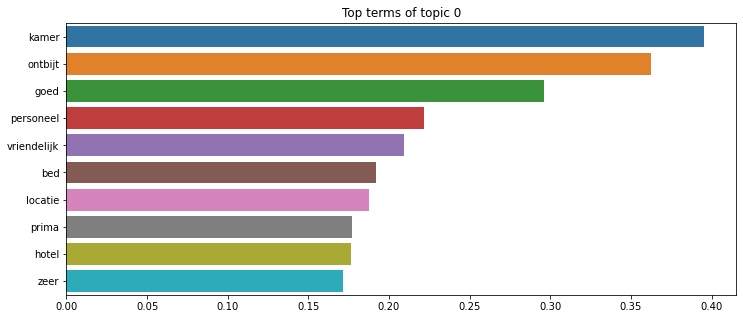

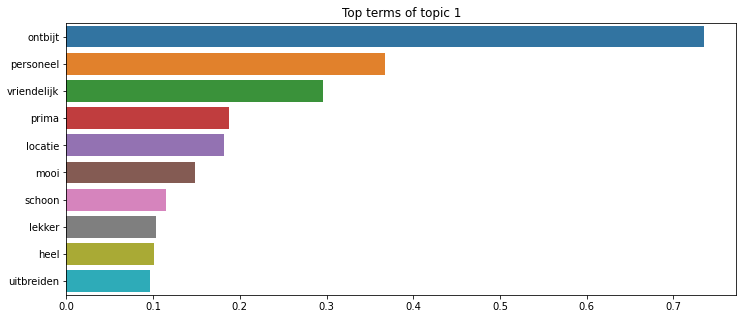

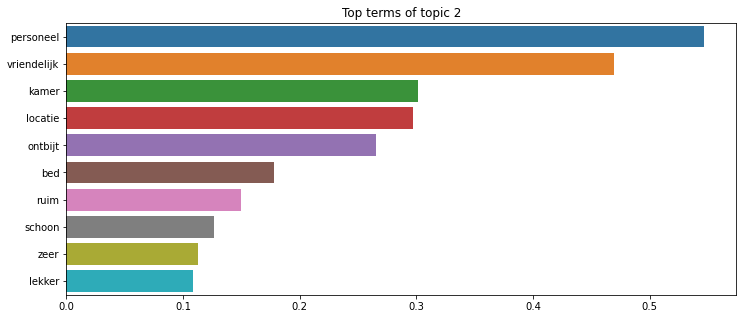

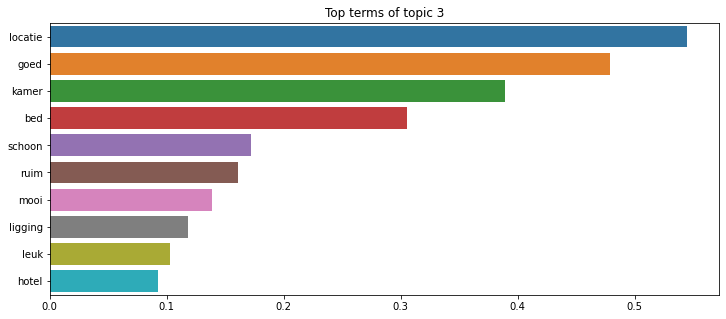

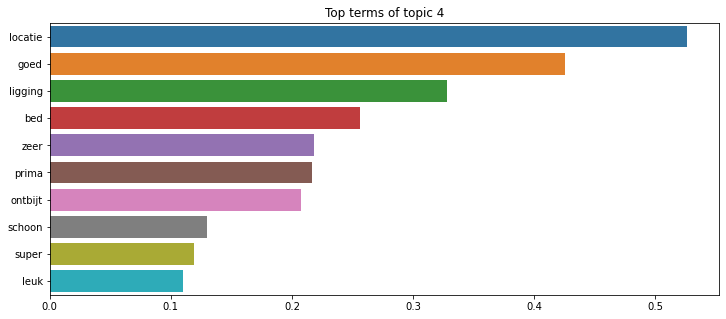

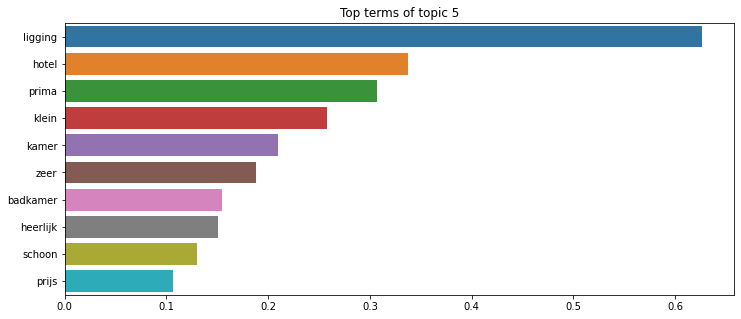

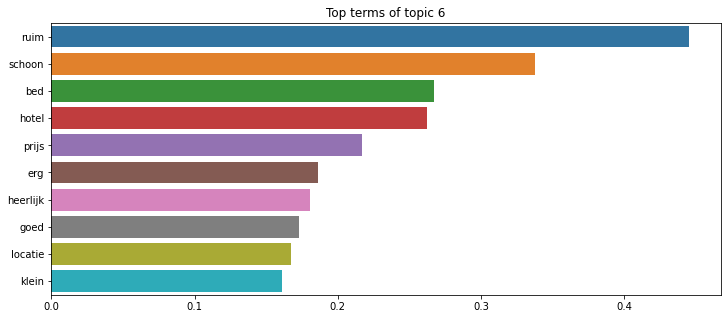

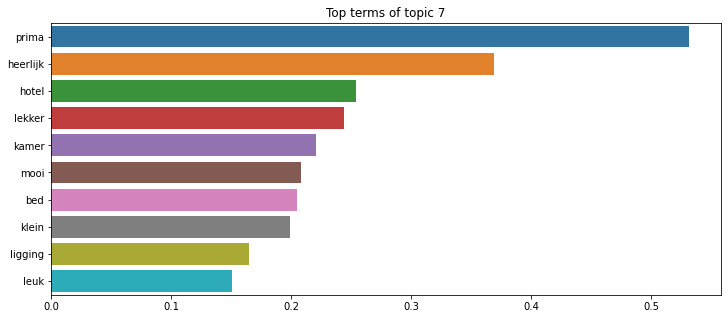

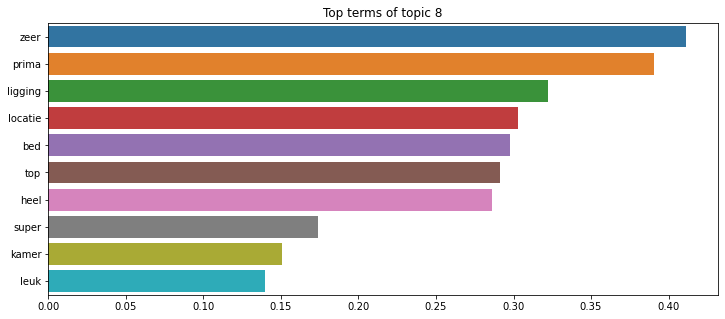

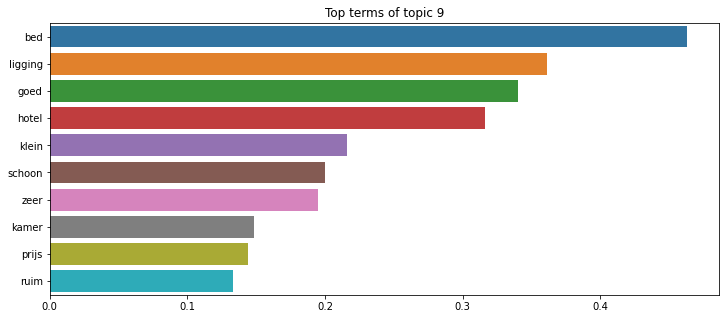

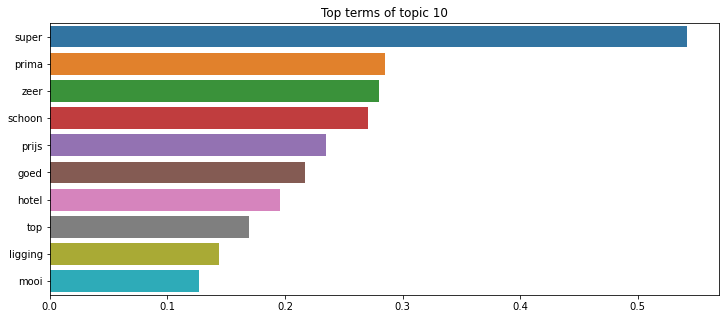

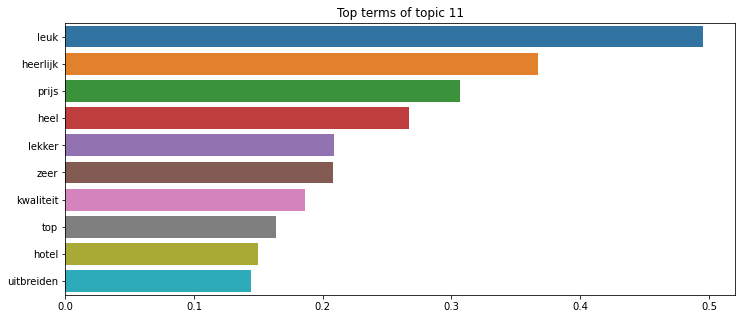

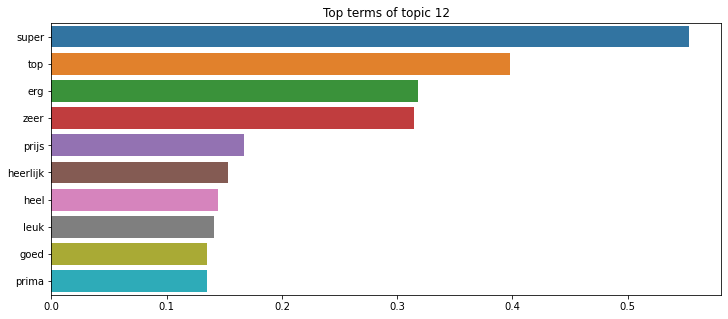

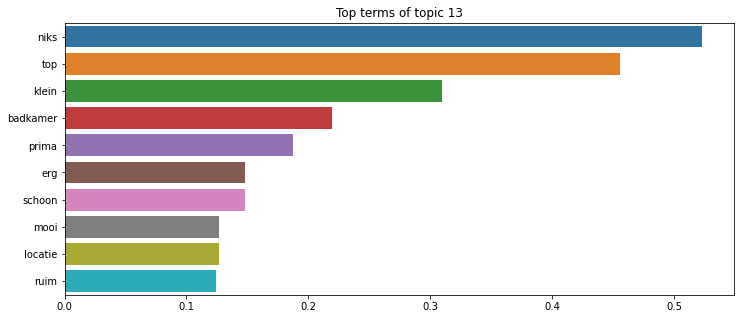

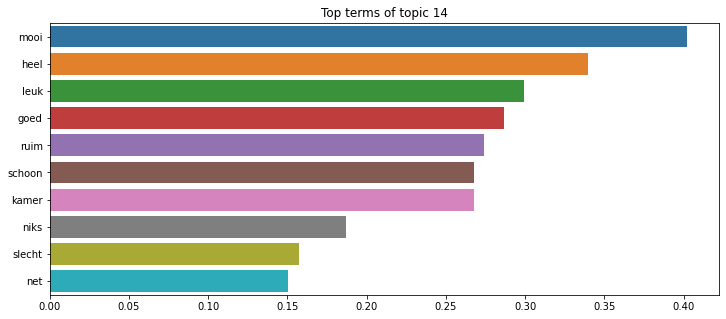

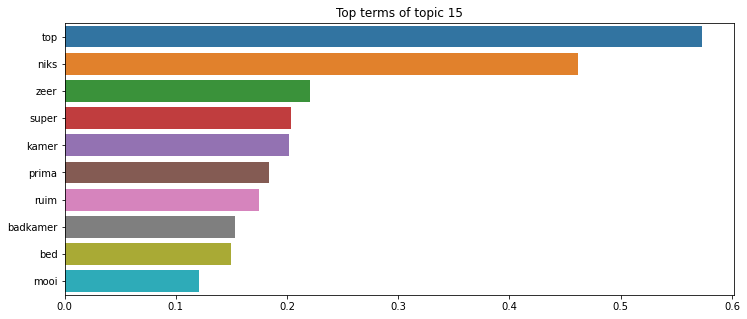

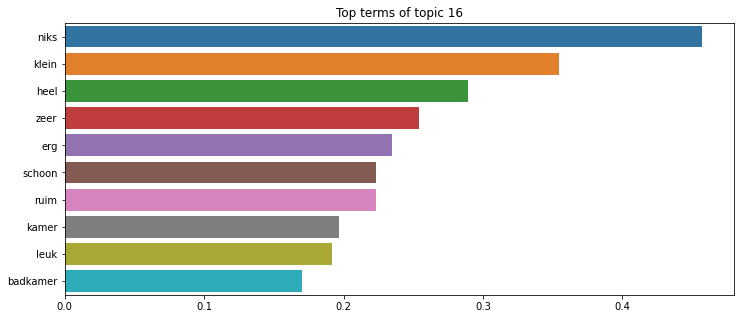

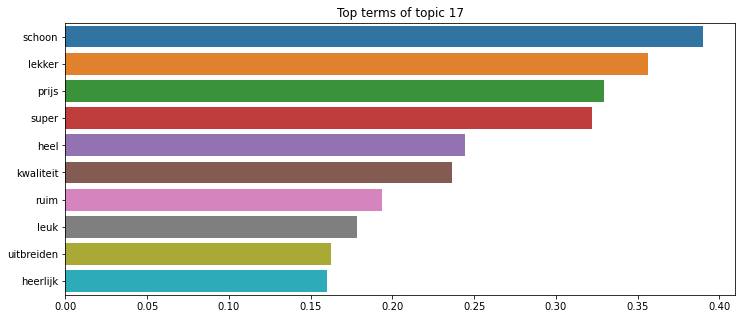

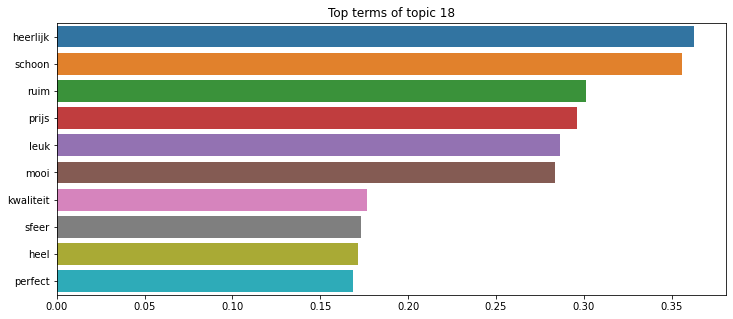

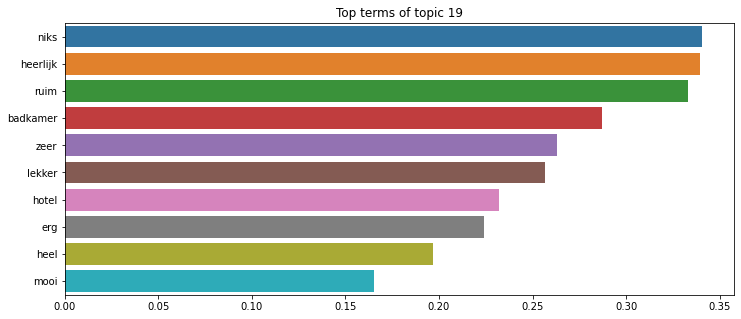

In [64]:
for i in range(20):
    plt.figure(figsize=(12,5))
    data = term_topic_matrix[f'topic_{i}']
    data = data.sort_values(ascending=False)
    top_10_pos = data[:10]
    ax = sns.barplot(x= top_10_pos.values, y=top_10_pos.index)
    ax.set_title(f'Top terms of topic {i}')

Either analyze it using an RF and get the most important topics or analyze it using that tsne thing

In [60]:
RF = RandomForestClassifier(n_estimators = 800,
                           max_depth = 50,
                           min_samples_leaf = 4,
                           max_features = 'log2',
                           class_weight = [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
                                           {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
                                           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
                                           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}])

In [61]:
doc_top_df = pd.DataFrame(lsa_data,
                          columns = [f'topic_{r+1}' for r in range(30)])
doc_top_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30
0,0.220451,-0.008732,-0.103586,0.168712,-0.185412,-0.053708,0.159076,-0.026221,-0.059541,0.010566,...,-0.074419,0.027335,-0.024263,-0.032109,0.096737,-0.036347,0.047355,-0.071553,0.058237,-0.074852
1,0.288871,0.362831,0.256727,-0.070315,-0.034639,-0.101026,0.064808,0.251188,0.174362,0.028172,...,-0.121725,-0.197116,-0.127955,0.183083,-0.087525,0.103373,0.035025,-0.003238,0.062502,-0.123636
2,0.107330,-0.029811,-0.082444,-0.021692,-0.013627,-0.031461,-0.003640,0.010972,0.034132,0.049534,...,0.075200,0.003391,-0.057979,-0.032023,0.033593,0.039269,-0.019408,0.046547,-0.050642,0.068094
3,0.171782,-0.025600,-0.056248,0.184036,-0.171593,0.011136,0.125227,0.061100,-0.062927,-0.042402,...,0.011274,-0.069248,-0.014786,-0.072719,-0.003279,-0.006856,-0.042143,0.034433,-0.058642,-0.061288
4,0.162253,-0.009812,-0.073180,0.049972,-0.107766,0.008980,0.091921,0.090787,-0.034754,0.033936,...,-0.004650,0.038381,-0.018598,0.041869,-0.017032,-0.012666,-0.038978,-0.037025,0.025435,0.169558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.144460,0.087098,-0.016514,-0.054912,0.000946,0.029016,-0.049404,0.156479,-0.031357,0.014174,...,0.011799,-0.001867,-0.026251,0.046452,-0.093815,-0.011571,0.025792,-0.066660,0.089454,-0.020281
1436,0.174823,-0.070279,-0.089935,-0.035018,-0.053883,-0.041673,-0.012687,0.038847,-0.096500,-0.010124,...,0.054095,0.091442,0.012852,-0.125426,-0.115135,-0.107589,-0.032351,-0.020147,-0.045195,-0.011355
1437,0.133588,-0.045622,-0.100264,-0.027746,-0.085158,-0.026444,-0.042924,0.042253,-0.040441,0.052428,...,0.024480,-0.020257,0.026189,0.079119,0.084024,0.016160,0.005664,0.052802,-0.040503,0.139127
1438,0.127712,0.104919,-0.017364,-0.042730,0.021695,-0.045208,-0.006478,-0.029622,0.011330,-0.008080,...,-0.049531,0.078348,0.058933,0.017429,-0.039149,-0.056741,0.027079,0.072722,-0.063676,-0.033280


In [62]:
RF.fit(doc_top_df, Y)

RandomForestClassifier(class_weight=[{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66},
                                     {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67},
                                     {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6},
                                     {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}],
                       max_depth=50, max_features='log2', min_samples_leaf=4,
                       n_estimators=800)

In [63]:
pd.DataFrame(RF.feature_importances_, index = doc_top_df.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
topic_6,0.086771
topic_7,0.048668
topic_19,0.046669
topic_22,0.038956
topic_5,0.035916
topic_10,0.035066
topic_12,0.034072
topic_15,0.033255
topic_9,0.032781
topic_26,0.031731


the three most important topics here seem to be 6, 19 and 7. Topic 6 seems to be more about the location of the hotel, topic 7 about the room itself and topic 19 more about the atmosphere of the hotel. 

## with 100 iterations

In [61]:
cv = CountVectorizer()
data_cv = cv.fit_transform(body.clean_text_lemma)
dtm_CV = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

tfidf = TfidfVectorizer()
data_tfidf = tfidf.fit_transform(body.clean_text_lemma)
dtm_tfidf = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names())

lsa_obj = TruncatedSVD(n_components=30, n_iter=100, random_state=0)
lsa_data = lsa_obj.fit_transform(dtm_tfidf)

In [100]:
lda_obj = LatentDirichletAllocation(n_components=25,
                              doc_topic_prior = 0.1,
                              topic_word_prior = 1,
                              n_jobs=-1, random_state=0)
lda_data = lda_obj.fit_transform(dtm_CV)

In [64]:
# show terms per topic
words = cv.get_feature_names()
for topic_idx, topic in enumerate(lsa_obj.components_):
    print(f"\nTopic #{topic_idx+1}:")
    print("; ".join([words[i]
                    for i in topic.argsort()[:-10-2:-1]]))


Topic #1:
kamer; ontbijt; goed; personeel; vriendelijk; bed; locatie; prima; hotel; zeer; heel

Topic #2:
ontbijt; prima; lekker; uitbreiden; goed; uitstekend; zeer; heerlijk; weinig; plaats; keuze

Topic #3:
personeel; vriendelijk; ontbijt; zeer; lekker; uitbreiden; heel; super; behulpzaam; vriendelijkheid; proper

Topic #4:
locatie; goed; bed; uitstekend; niks; douche; prima; personeel; service; comfortabel; slecht

Topic #5:
locatie; prima; ontbijt; schoon; super; leuk; vriendelijk; personeel; kamer; top; ruim

Topic #6:
ligging; hotel; prima; heerlijk; schoon; perfect; centraal; mooi; centrum; leuk; sfeer

Topic #7:
ruim; schoon; bed; heerlijk; goed; zeer; mooi; kamer; fijn; prima; vriendelijk

Topic #8:
heerlijk; hotel; lekker; mooi; bed; leuk; super; ontbijt; uitbreiden; liggen; echt

Topic #9:
zeer; ligging; locatie; top; kamer; ruim; perfect; proper; prachtig; vriendelijkheid; uitstekend

Topic #10:
bed; ligging; klein; kamer; heerlijk; slecht; lekker; badkamer; comfortabel; t

#### LSA 

In [66]:
RF = RandomForestClassifier(n_estimators = 800,
                           max_depth = 50,
                           min_samples_leaf = 4,
                           min_samples_split = 3,
                           max_features = 'log2',
                           class_weight = [{0:0.32, 1:0.68}, {0:0.34, 1:0.66}, 
                                        {0:0.4, 1:0.6}, {0:0.33, 1:0.67}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}, 
           {0:0.4, 1:0.6}, {0:0.4, 1:0.6}])

In [68]:
doc_top_df = pd.DataFrame(lsa_data,
                          columns = [f'topic_{r+1}' for r in range(30)])
doc_top_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30
0,0.220451,-0.008732,-0.103586,0.168712,-0.185412,-0.053708,0.159076,-0.026221,-0.059541,0.010566,...,-0.074419,0.027335,-0.024263,-0.032109,0.096737,-0.036347,0.047355,-0.071553,0.058237,-0.074852
1,0.288871,0.362831,0.256727,-0.070315,-0.034639,-0.101026,0.064808,0.251188,0.174362,0.028172,...,-0.121725,-0.197116,-0.127955,0.183083,-0.087525,0.103373,0.035025,-0.003238,0.062502,-0.123636
2,0.107330,-0.029811,-0.082444,-0.021692,-0.013627,-0.031461,-0.003640,0.010972,0.034132,0.049534,...,0.075200,0.003391,-0.057979,-0.032023,0.033593,0.039269,-0.019408,0.046547,-0.050642,0.068094
3,0.171782,-0.025600,-0.056248,0.184036,-0.171593,0.011136,0.125227,0.061100,-0.062927,-0.042402,...,0.011274,-0.069248,-0.014786,-0.072719,-0.003279,-0.006856,-0.042143,0.034433,-0.058642,-0.061288
4,0.162253,-0.009812,-0.073180,0.049972,-0.107766,0.008980,0.091921,0.090787,-0.034754,0.033936,...,-0.004650,0.038381,-0.018598,0.041869,-0.017032,-0.012666,-0.038978,-0.037025,0.025435,0.169558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.144460,0.087098,-0.016514,-0.054912,0.000946,0.029016,-0.049404,0.156479,-0.031357,0.014174,...,0.011799,-0.001867,-0.026251,0.046452,-0.093815,-0.011571,0.025792,-0.066660,0.089454,-0.020281
1436,0.174823,-0.070279,-0.089935,-0.035018,-0.053883,-0.041673,-0.012687,0.038847,-0.096500,-0.010124,...,0.054095,0.091442,0.012852,-0.125426,-0.115135,-0.107589,-0.032351,-0.020147,-0.045195,-0.011355
1437,0.133588,-0.045622,-0.100264,-0.027746,-0.085158,-0.026444,-0.042924,0.042253,-0.040441,0.052428,...,0.024480,-0.020257,0.026189,0.079119,0.084024,0.016160,0.005664,0.052802,-0.040503,0.139127
1438,0.127712,0.104919,-0.017364,-0.042730,0.021695,-0.045208,-0.006478,-0.029622,0.011330,-0.008080,...,-0.049531,0.078348,0.058933,0.017429,-0.039149,-0.056741,0.027079,0.072722,-0.063676,-0.033280


In [69]:
RF.fit(doc_top_df, Y)

RandomForestClassifier(class_weight=[{0: 0.32, 1: 0.68}, {0: 0.34, 1: 0.66},
                                     {0: 0.4, 1: 0.6}, {0: 0.33, 1: 0.67},
                                     {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6},
                                     {0: 0.4, 1: 0.6}, {0: 0.4, 1: 0.6}],
                       max_depth=50, max_features='log2', min_samples_leaf=4,
                       min_samples_split=3, n_estimators=800)

In [70]:
pd.DataFrame(RF.feature_importances_, index = doc_top_df.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
topic_6,0.086279
topic_7,0.048504
topic_19,0.048017
topic_22,0.038560
topic_5,0.036460
topic_10,0.035801
topic_12,0.034551
topic_9,0.033932
topic_26,0.031760
topic_27,0.031427


### take best 10 from above

## Plotting using pyldavis

In [58]:
import pyLDAvis
import pyLDAvis.sklearn

#enable the interactive display
pyLDAvis.enable_notebook()
cv = CountVectorizer()

#this is by far the easiest way to load a pre-trained sklearn lda model onto pyLDAvis
#there are other means of using this visible on pyLDAvis' main repo

display_data = pyLDAvis.sklearn.prepare(lda_obj, #our pre-trained LDA model
                         cv.fit_transform(body.clean_text_lemma), #this gives us our document-term matrix
                        cv) #the vectoriser object
                        
pyLDAvis.display(display_data) 